In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('C:/Users/rncid/Desktop/Machine Learning/water_quality.csv')
df.head()

ModuleNotFoundError: No module named 'pandas'

In [2]:
!pip install pandas



   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --------------- ------------------------ 4.2/11.0 MB 26.5 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 28.3 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 20.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install seaborn matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------------- ------------ 5.5/8.1 MB 31.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 26.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 23.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 35.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
### Step 1: Importing Necessary Libraries
import pandas as pd  # For data manipulation
import torch  # PyTorch for building neural networks
import torch.nn as nn  # PyTorch neural network modules
import torch.optim as optim  # PyTorch optimization algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import r2_score, f1_score  # For evaluating model performance
import numpy as np  # For numerical operations


### Step 2: Loading and Preparing Dataset
file_path = 'C:/Users/Sanjana Shah/AV GenAI Certification/DL_Pytorch/Assignment/water_quality.csv'  # Path to the dataset file
water_quality_df = pd.read_csv(file_path)  # Reading the dataset into a DataFrame


### Step 2.1: Handling Missing and Infinite Values

# Replacing NaN values with column means to avoid issues with missing data
if water_quality_df.isnull().sum().sum() > 0:
    print("Replacing NaN values with column means.")
    water_quality_df.fillna(water_quality_df.mean(numeric_only=True), inplace=True)

# Replacing Inf values with 0 to avoid computational errors
numeric_cols = water_quality_df.select_dtypes(include=[np.number]).columns
water_quality_df[numeric_cols] = water_quality_df[numeric_cols].replace([np.inf, -np.inf], 0)


### Step 3: Encoding Categorical Columns
categorical_columns = ['State', 'District', 'Block', 'Village']
# Label encoding categorical features to numerical values
for column in categorical_columns:
    water_quality_df[column] = LabelEncoder().fit_transform(water_quality_df[column].astype(str))


### Step 4: Encoding Target Column
# Encoding the categorical target column 'Water Quality Classification'
water_quality_df['Water Quality Classification'] = LabelEncoder().fit_transform(water_quality_df['Water Quality Classification'].astype(str))


### Step 5: Preparing Features and Targets
# Dropping unwanted columns and setting features and targets
X = water_quality_df.drop(['WQI', 'Water Quality Classification', 'Well_ID'], axis=1)

y_reg = water_quality_df['WQI']  # Regression target

y_clf = water_quality_df['Water Quality Classification']  # Classification target


### Step 6: Data Scaling
scaler = StandardScaler()  # Standardizing features (mean=0, variance=1)
X_scaled = scaler.fit_transform(X)  # Applying scaling to the feature data


### Step 7: Train/Test Split
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.2, random_state=42
)


### Step 8: Convert Data to PyTorch Tensors
# Converting data to tensors for PyTorch compatibility
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_reg_tensor = torch.tensor(y_train_reg.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension

# Regression and Classification targets
y_test_reg_tensor = torch.tensor(y_test_reg.values, dtype=torch.float32).unsqueeze(1)
y_train_clf_tensor = torch.tensor(y_train_clf.values, dtype=torch.long)
y_test_clf_tensor = torch.tensor(y_test_clf.values, dtype=torch.long)


### Step 9: Define Improved Neural Network Model
class ImprovedNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNetwork, self).__init__()
        # Shared Network Layers
        self.shared = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        # Separate layers for regression and classification
        self.regressor = nn.Linear(64, 1)  # Regression output layer
        self.classifier = nn.Linear(64, 5)  # Classification output layer

    def forward(self, x):
        shared_features = self.shared(x)  # Passing data through shared layers
        reg_output = self.regressor(shared_features)  # Producing regression output
        clf_output = self.classifier(shared_features)  # Producing classification output
        return reg_output, clf_output


### Step 10: Initializing Model, Losses, and Optimizer
model = ImprovedNetwork()  # Initializing the neural network

criterion_reg = nn.SmoothL1Loss()  # Regression loss function (better for small errors)
criterion_clf = nn.CrossEntropyLoss()  # Classification loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)  # Using AdamW optimizer

# Learning rate scheduler for dynamic adjustment of learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


### Step 11: Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    y_pred_reg_train, y_pred_clf_train = model(X_train_tensor)

    # Calculating training losses
    train_loss_reg = criterion_reg(y_pred_reg_train, y_train_reg_tensor / 1000)  # Scaling target
    train_loss_clf = criterion_clf(y_pred_clf_train, y_train_clf_tensor)
    train_loss = train_loss_reg + train_loss_clf

    # Backpropagation
    train_loss.backward()
    optimizer.step()
    scheduler.step(train_loss)

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_pred_reg_test, y_pred_clf_test = model(X_test_tensor)
        test_loss_reg = criterion_reg(y_pred_reg_test, y_test_reg_tensor / 1000)
        test_loss_clf = criterion_clf(y_pred_clf_test, y_test_clf_tensor)
        test_loss = test_loss_reg + test_loss_clf

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


### Step 12: Evaluating Model Performance
model.eval()
with torch.no_grad():
    y_test_pred_reg, y_test_pred_clf = model(X_test_tensor)

    r2 = r2_score(y_test_reg_tensor.numpy(), y_test_pred_reg.numpy())
    _, predicted_classes = torch.max(y_test_pred_clf, 1)
    f1 = f1_score(y_test_clf_tensor.numpy(), predicted_classes.numpy(), average='weighted')
    accuracy = (predicted_classes == y_test_clf_tensor).sum().item() / len(y_test_clf_tensor)

print(f'R² Score (Regression): {r2:.4f}')
print(f'F1 Score (Classification): {f1:.4f}')
print(f'Test Accuracy (Classification): {accuracy * 100:.2f}%')

ModuleNotFoundError: No module named 'torch'

In [4]:
!pip install torch torchvision torchaudio



   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
    --------------------------------------- 3.4/216.1 MB 21.9 MB/s eta 0:00:10
   - -------------------------------------- 8.1/216.1 MB 21.8 MB/s eta 0:00:10
   -- ------------------------------------- 13.4/216.1 MB 22.9 MB/s eta 0:00:09
   --- ------------------------------------ 18.6/216.1 MB 23.0 MB/s eta 0:00:09
   ---- ----------------------------------- 23.6/216.1 MB 23.1 MB/s eta 0:00:09
   ----- ---------------------------------- 28.8/216.1 MB 23.4 MB/s eta 0:00:09
   ------ --------------------------------- 34.1/216.1 MB 23.4 MB/s eta 0:00:08
   ------- -------------------------------- 39.6/216.1 MB 23.7 MB/s eta 0:00:08
   -------- ------------------------------- 44.8/216.1 MB 23.8 MB/s eta 0:00:08
   --------- ------------------------------ 50.3/216.1 MB 24.0 MB/s eta 0:00:07
   ---------- ----------------------------- 56.1/216.1 MB 24.1 MB/s eta 0:00:07
   ----------- ---------------------------- 61.6/21

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install torch torchvision torchaudio


  Using cached torch-2.7.1-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
Using cached torch-2.7.1-cp313-cp313-win_amd64.whl (216.1 MB)
Using cached torchvision-0.22.1-cp313-cp313-win_amd64.whl (1.7 MB)
Using cached torchaudio-2.7.1-cp313-cp313-win_amd64.whl (2.5 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
### Step 1: Importing Necessary Libraries
import pandas as pd  # For data manipulation
import torch  # PyTorch for building neural networks
import torch.nn as nn  # PyTorch neural network modules
import torch.optim as optim  # PyTorch optimization algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import r2_score, f1_score  # For evaluating model performance
import numpy as np  # For numerical operations


### Step 2: Loading and Preparing Dataset
file_path = 'C:/Users/Sanjana Shah/AV GenAI Certification/DL_Pytorch/Assignment/water_quality.csv'  # Path to the dataset file
water_quality_df = pd.read_csv(file_path)  # Reading the dataset into a DataFrame


### Step 2.1: Handling Missing and Infinite Values

# Replacing NaN values with column means to avoid issues with missing data
if water_quality_df.isnull().sum().sum() > 0:
    print("Replacing NaN values with column means.")
    water_quality_df.fillna(water_quality_df.mean(numeric_only=True), inplace=True)

# Replacing Inf values with 0 to avoid computational errors
numeric_cols = water_quality_df.select_dtypes(include=[np.number]).columns
water_quality_df[numeric_cols] = water_quality_df[numeric_cols].replace([np.inf, -np.inf], 0)


### Step 3: Encoding Categorical Columns
categorical_columns = ['State', 'District', 'Block', 'Village']
# Label encoding categorical features to numerical values
for column in categorical_columns:
    water_quality_df[column] = LabelEncoder().fit_transform(water_quality_df[column].astype(str))


### Step 4: Encoding Target Column
# Encoding the categorical target column 'Water Quality Classification'
water_quality_df['Water Quality Classification'] = LabelEncoder().fit_transform(water_quality_df['Water Quality Classification'].astype(str))


### Step 5: Preparing Features and Targets
# Dropping unwanted columns and setting features and targets
X = water_quality_df.drop(['WQI', 'Water Quality Classification', 'Well_ID'], axis=1)

y_reg = water_quality_df['WQI']  # Regression target

y_clf = water_quality_df['Water Quality Classification']  # Classification target


### Step 6: Data Scaling
scaler = StandardScaler()  # Standardizing features (mean=0, variance=1)
X_scaled = scaler.fit_transform(X)  # Applying scaling to the feature data


### Step 7: Train/Test Split
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.2, random_state=42
)


### Step 8: Convert Data to PyTorch Tensors
# Converting data to tensors for PyTorch compatibility
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_reg_tensor = torch.tensor(y_train_reg.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension

# Regression and Classification targets
y_test_reg_tensor = torch.tensor(y_test_reg.values, dtype=torch.float32).unsqueeze(1)
y_train_clf_tensor = torch.tensor(y_train_clf.values, dtype=torch.long)
y_test_clf_tensor = torch.tensor(y_test_clf.values, dtype=torch.long)


### Step 9: Define Improved Neural Network Model
class ImprovedNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNetwork, self).__init__()
        # Shared Network Layers
        self.shared = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        # Separate layers for regression and classification
        self.regressor = nn.Linear(64, 1)  # Regression output layer
        self.classifier = nn.Linear(64, 5)  # Classification output layer

    def forward(self, x):
        shared_features = self.shared(x)  # Passing data through shared layers
        reg_output = self.regressor(shared_features)  # Producing regression output
        clf_output = self.classifier(shared_features)  # Producing classification output
        return reg_output, clf_output


### Step 10: Initializing Model, Losses, and Optimizer
model = ImprovedNetwork()  # Initializing the neural network

criterion_reg = nn.SmoothL1Loss()  # Regression loss function (better for small errors)
criterion_clf = nn.CrossEntropyLoss()  # Classification loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)  # Using AdamW optimizer

# Learning rate scheduler for dynamic adjustment of learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


### Step 11: Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    y_pred_reg_train, y_pred_clf_train = model(X_train_tensor)

    # Calculating training losses
    train_loss_reg = criterion_reg(y_pred_reg_train, y_train_reg_tensor / 1000)  # Scaling target
    train_loss_clf = criterion_clf(y_pred_clf_train, y_train_clf_tensor)
    train_loss = train_loss_reg + train_loss_clf

    # Backpropagation
    train_loss.backward()
    optimizer.step()
    scheduler.step(train_loss)

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_pred_reg_test, y_pred_clf_test = model(X_test_tensor)
        test_loss_reg = criterion_reg(y_pred_reg_test, y_test_reg_tensor / 1000)
        test_loss_clf = criterion_clf(y_pred_clf_test, y_test_clf_tensor)
        test_loss = test_loss_reg + test_loss_clf

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


### Step 12: Evaluating Model Performance
model.eval()
with torch.no_grad():
    y_test_pred_reg, y_test_pred_clf = model(X_test_tensor)

    r2 = r2_score(y_test_reg_tensor.numpy(), y_test_pred_reg.numpy())
    _, predicted_classes = torch.max(y_test_pred_clf, 1)
    f1 = f1_score(y_test_clf_tensor.numpy(), predicted_classes.numpy(), average='weighted')
    accuracy = (predicted_classes == y_test_clf_tensor).sum().item() / len(y_test_clf_tensor)

print(f'R² Score (Regression): {r2:.4f}')
print(f'F1 Score (Classification): {f1:.4f}')
print(f'Test Accuracy (Classification): {accuracy * 100:.2f}%')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Sanjana Shah/AV GenAI Certification/DL_Pytorch/Assignment/water_quality.csv'

In [7]:
### Step 1: Importing Necessary Libraries
import pandas as pd  # For data manipulation
import torch  # PyTorch for building neural networks
import torch.nn as nn  # PyTorch neural network modules
import torch.optim as optim  # PyTorch optimization algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Data preprocessing tools
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import r2_score, f1_score  # For evaluating model performance
import numpy as np  # For numerical operations


### Step 2: Loading and Preparing Dataset
file_path = 'D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv'  # Path to the dataset file
water_quality_df = pd.read_csv(file_path)  # Reading the dataset into a DataFrame


### Step 2.1: Handling Missing and Infinite Values

# Replacing NaN values with column means to avoid issues with missing data
if water_quality_df.isnull().sum().sum() > 0:
    print("Replacing NaN values with column means.")
    water_quality_df.fillna(water_quality_df.mean(numeric_only=True), inplace=True)

# Replacing Inf values with 0 to avoid computational errors
numeric_cols = water_quality_df.select_dtypes(include=[np.number]).columns
water_quality_df[numeric_cols] = water_quality_df[numeric_cols].replace([np.inf, -np.inf], 0)


### Step 3: Encoding Categorical Columns
categorical_columns = ['State', 'District', 'Block', 'Village']
# Label encoding categorical features to numerical values
for column in categorical_columns:
    water_quality_df[column] = LabelEncoder().fit_transform(water_quality_df[column].astype(str))


### Step 4: Encoding Target Column
# Encoding the categorical target column 'Water Quality Classification'
water_quality_df['Water Quality Classification'] = LabelEncoder().fit_transform(water_quality_df['Water Quality Classification'].astype(str))


### Step 5: Preparing Features and Targets
# Dropping unwanted columns and setting features and targets
X = water_quality_df.drop(['WQI', 'Water Quality Classification', 'Well_ID'], axis=1)

y_reg = water_quality_df['WQI']  # Regression target

y_clf = water_quality_df['Water Quality Classification']  # Classification target


### Step 6: Data Scaling
scaler = StandardScaler()  # Standardizing features (mean=0, variance=1)
X_scaled = scaler.fit_transform(X)  # Applying scaling to the feature data


### Step 7: Train/Test Split
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_reg, y_clf, test_size=0.2, random_state=42
)


### Step 8: Convert Data to PyTorch Tensors
# Converting data to tensors for PyTorch compatibility
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_reg_tensor = torch.tensor(y_train_reg.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension

# Regression and Classification targets
y_test_reg_tensor = torch.tensor(y_test_reg.values, dtype=torch.float32).unsqueeze(1)
y_train_clf_tensor = torch.tensor(y_train_clf.values, dtype=torch.long)
y_test_clf_tensor = torch.tensor(y_test_clf.values, dtype=torch.long)


### Step 9: Define Improved Neural Network Model
class ImprovedNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNetwork, self).__init__()
        # Shared Network Layers
        self.shared = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        # Separate layers for regression and classification
        self.regressor = nn.Linear(64, 1)  # Regression output layer
        self.classifier = nn.Linear(64, 5)  # Classification output layer

    def forward(self, x):
        shared_features = self.shared(x)  # Passing data through shared layers
        reg_output = self.regressor(shared_features)  # Producing regression output
        clf_output = self.classifier(shared_features)  # Producing classification output
        return reg_output, clf_output


### Step 10: Initializing Model, Losses, and Optimizer
model = ImprovedNetwork()  # Initializing the neural network

criterion_reg = nn.SmoothL1Loss()  # Regression loss function (better for small errors)
criterion_clf = nn.CrossEntropyLoss()  # Classification loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)  # Using AdamW optimizer

# Learning rate scheduler for dynamic adjustment of learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


### Step 11: Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    y_pred_reg_train, y_pred_clf_train = model(X_train_tensor)

    # Calculating training losses
    train_loss_reg = criterion_reg(y_pred_reg_train, y_train_reg_tensor / 1000)  # Scaling target
    train_loss_clf = criterion_clf(y_pred_clf_train, y_train_clf_tensor)
    train_loss = train_loss_reg + train_loss_clf

    # Backpropagation
    train_loss.backward()
    optimizer.step()
    scheduler.step(train_loss)

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_pred_reg_test, y_pred_clf_test = model(X_test_tensor)
        test_loss_reg = criterion_reg(y_pred_reg_test, y_test_reg_tensor / 1000)
        test_loss_clf = criterion_clf(y_pred_clf_test, y_test_clf_tensor)
        test_loss = test_loss_reg + test_loss_clf

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


### Step 12: Evaluating Model Performance
model.eval()
with torch.no_grad():
    y_test_pred_reg, y_test_pred_clf = model(X_test_tensor)

    r2 = r2_score(y_test_reg_tensor.numpy(), y_test_pred_reg.numpy())
    _, predicted_classes = torch.max(y_test_pred_clf, 1)
    f1 = f1_score(y_test_clf_tensor.numpy(), predicted_classes.numpy(), average='weighted')
    accuracy = (predicted_classes == y_test_clf_tensor).sum().item() / len(y_test_clf_tensor)

print(f'R² Score (Regression): {r2:.4f}')
print(f'F1 Score (Classification): {f1:.4f}')
print(f'Test Accuracy (Classification): {accuracy * 100:.2f}%')

Replacing NaN values with column means.
Epoch 5: Train Loss: 1.6036, Test Loss: 1.6179
Epoch 10: Train Loss: 1.4135, Test Loss: 1.5374
Epoch 15: Train Loss: 1.2808, Test Loss: 1.4196
Epoch 20: Train Loss: 1.1767, Test Loss: 1.2776
Epoch 25: Train Loss: 1.0891, Test Loss: 1.1364
Epoch 30: Train Loss: 1.0125, Test Loss: 1.0126
Epoch 35: Train Loss: 0.9427, Test Loss: 0.9121
Epoch 40: Train Loss: 0.8819, Test Loss: 0.8313
Epoch 45: Train Loss: 0.8287, Test Loss: 0.7656
Epoch 50: Train Loss: 0.7747, Test Loss: 0.7102
Epoch 55: Train Loss: 0.7324, Test Loss: 0.6623
Epoch 60: Train Loss: 0.6921, Test Loss: 0.6185
Epoch 65: Train Loss: 0.6524, Test Loss: 0.5791
Epoch 70: Train Loss: 0.6242, Test Loss: 0.5430
Epoch 75: Train Loss: 0.5965, Test Loss: 0.5115
Epoch 80: Train Loss: 0.5626, Test Loss: 0.4829
Epoch 85: Train Loss: 0.5421, Test Loss: 0.4569
Epoch 90: Train Loss: 0.5163, Test Loss: 0.4324
Epoch 95: Train Loss: 0.4940, Test Loss: 0.4105
Epoch 100: Train Loss: 0.4746, Test Loss: 0.3918


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

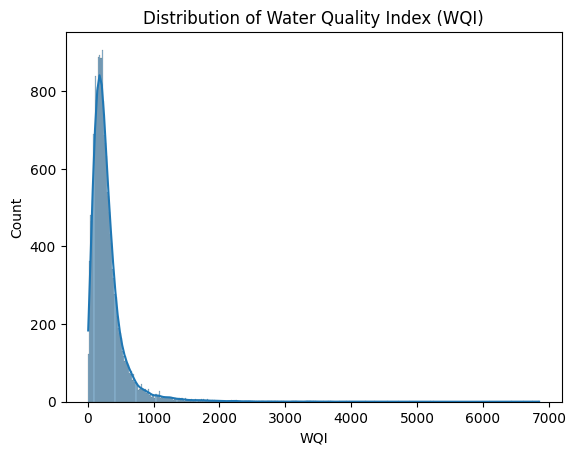

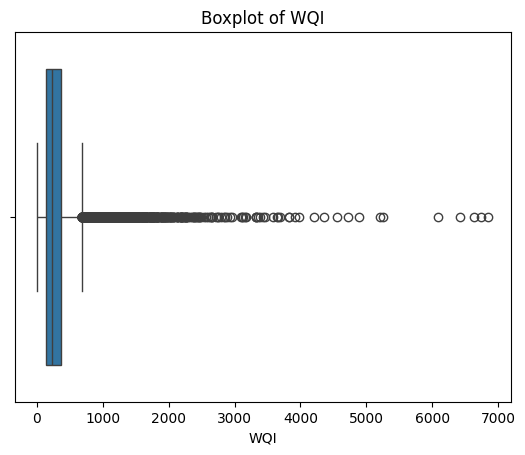

Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


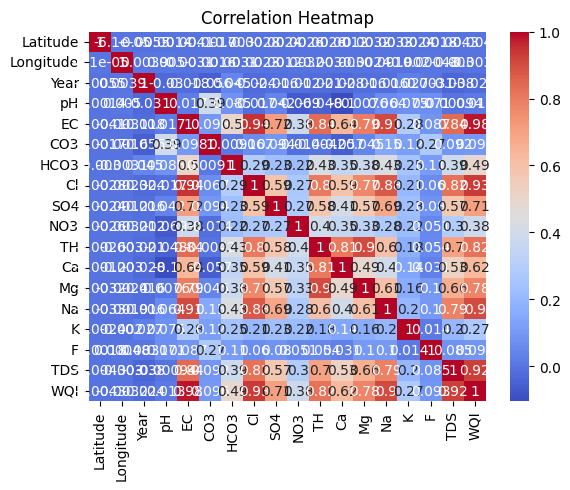

Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


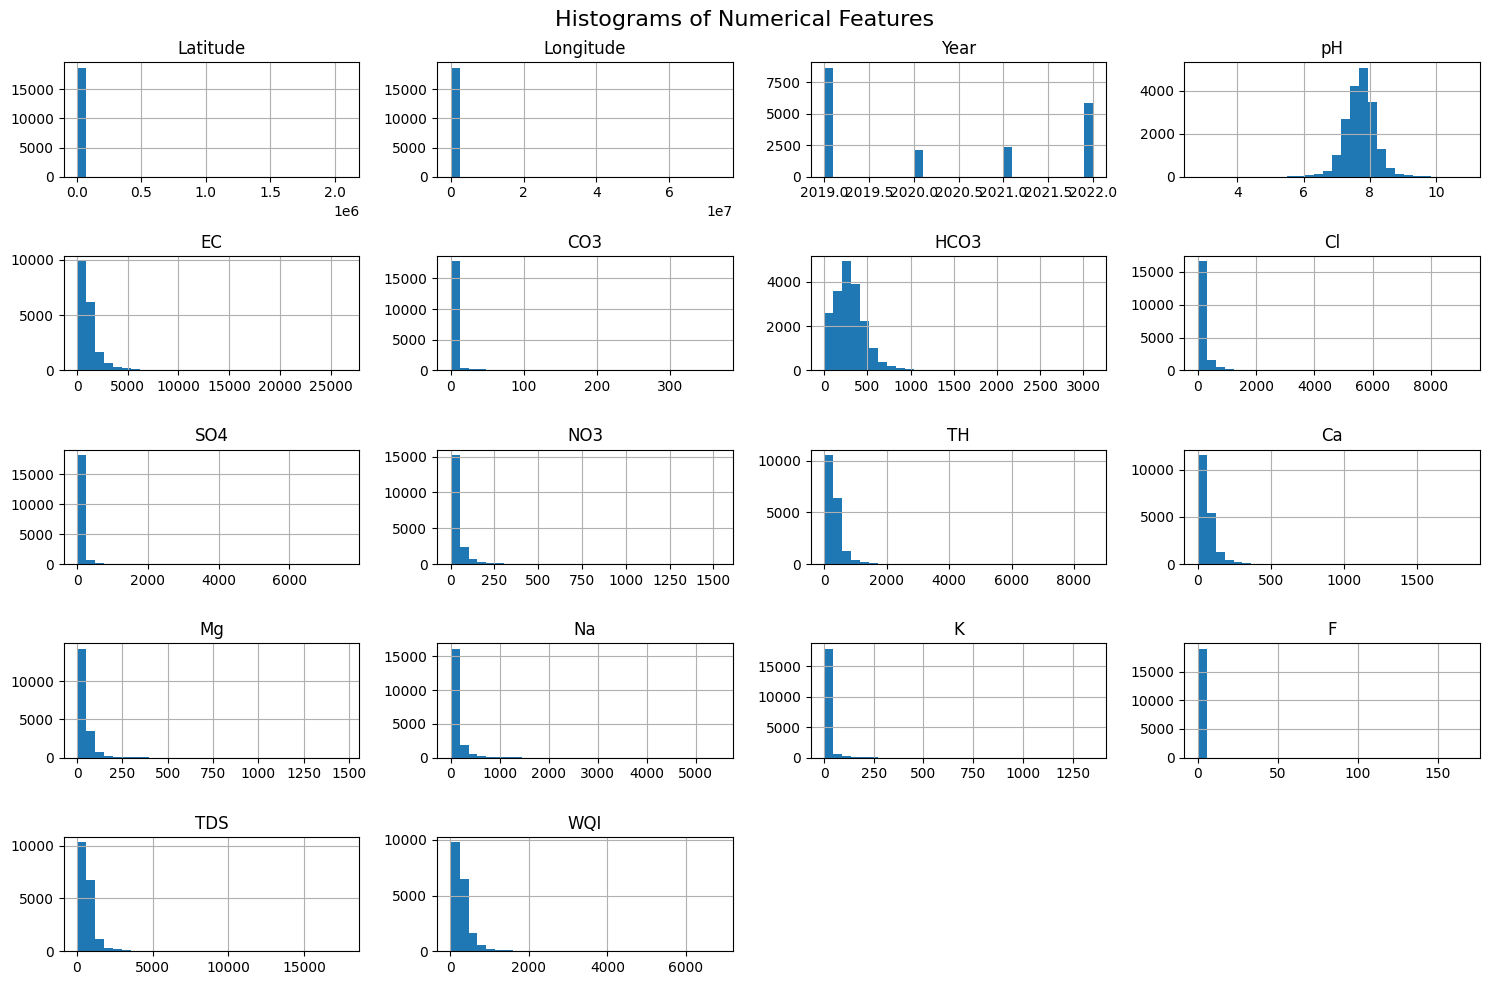

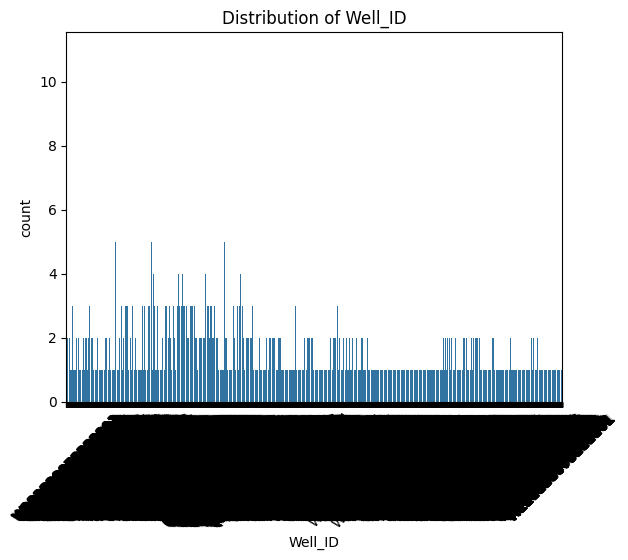

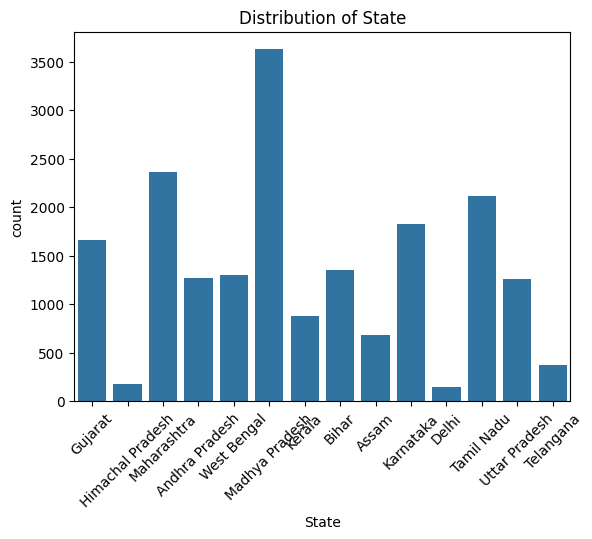

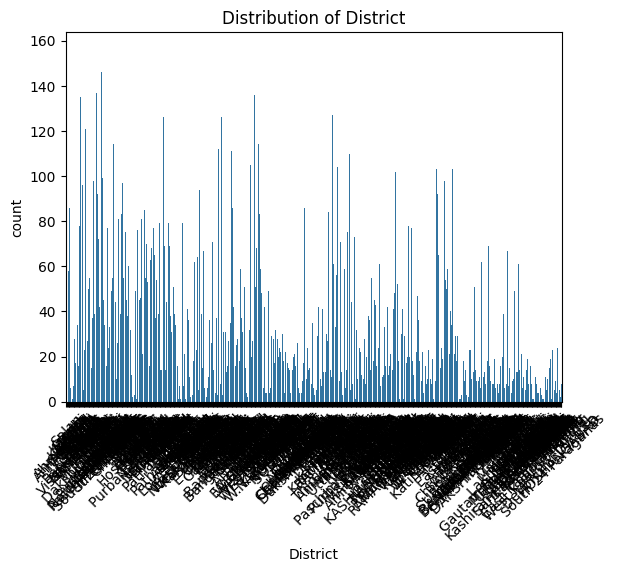

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

top_features = ['EC', 'Cl', 'TDS', 'Na', 'TH']
for feature in top_features:
    sns.scatterplot(data=df, x=feature, y='WQI')
    plt.title(f"{feature} vs WQI")
    plt.show()

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

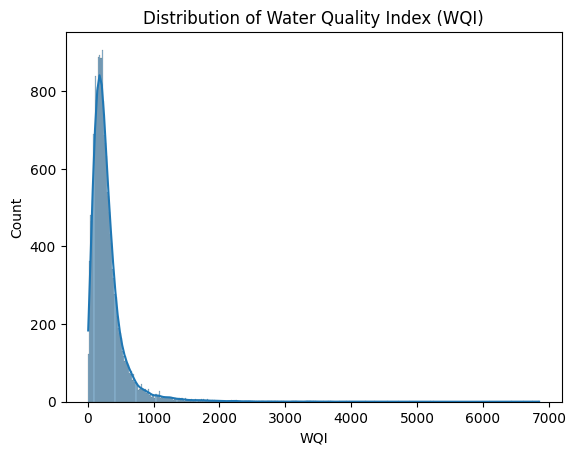

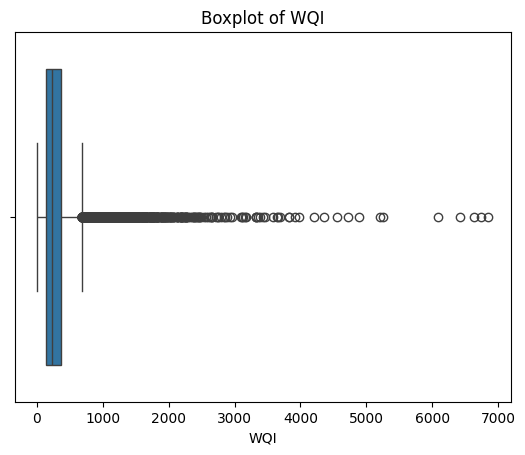

Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


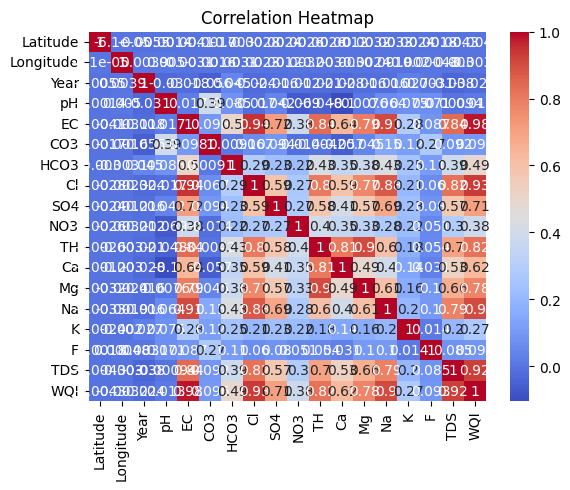

Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


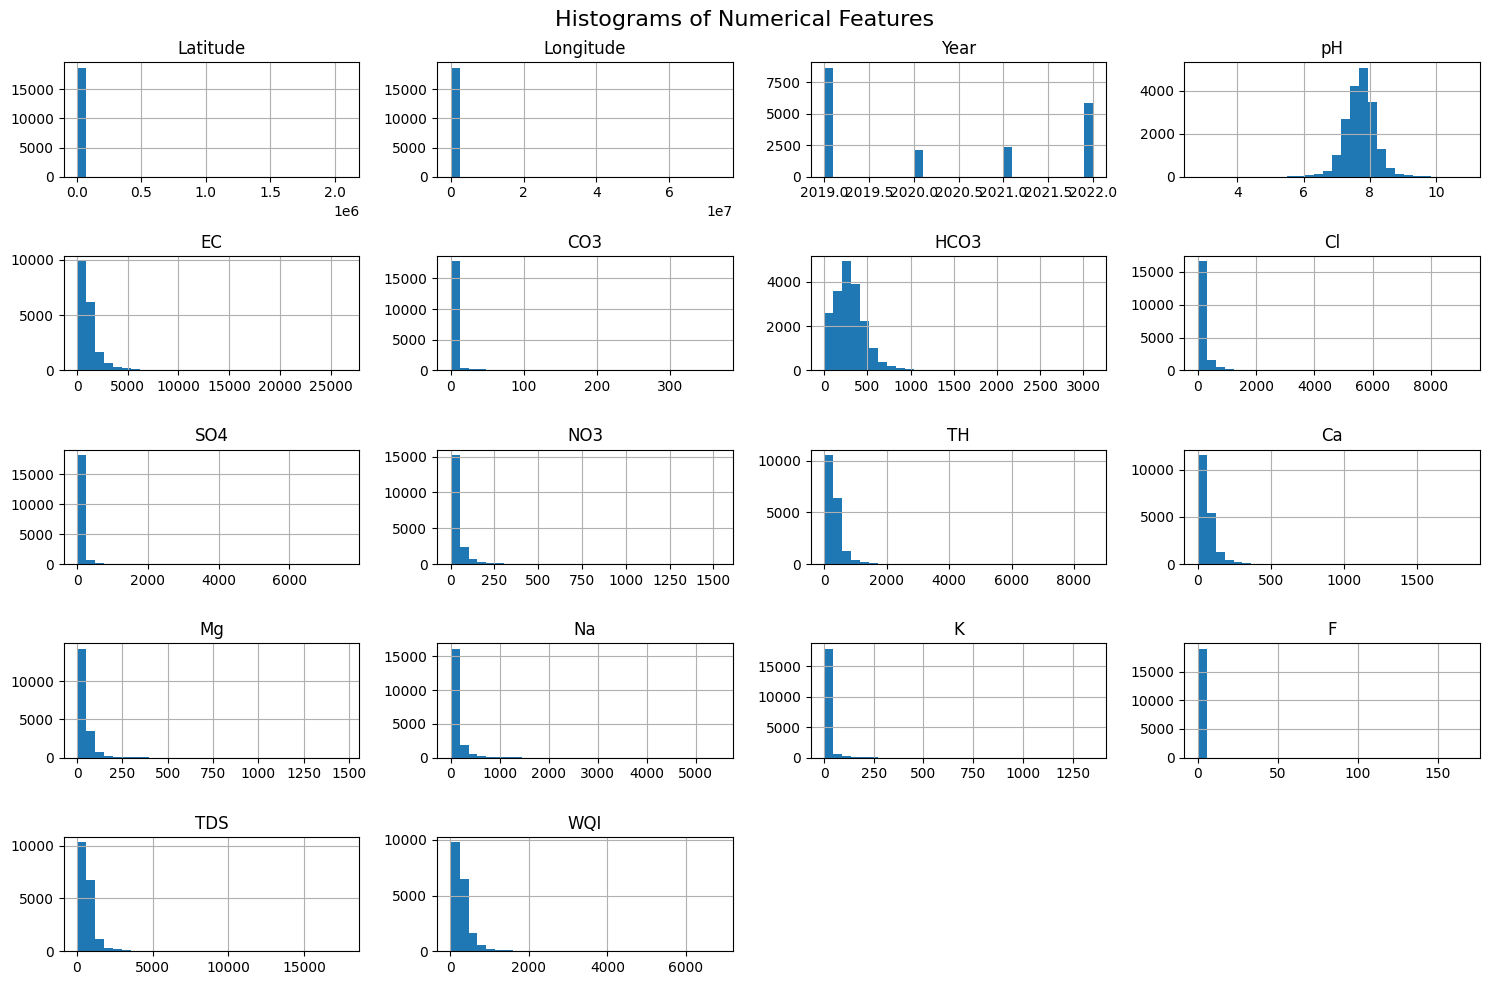

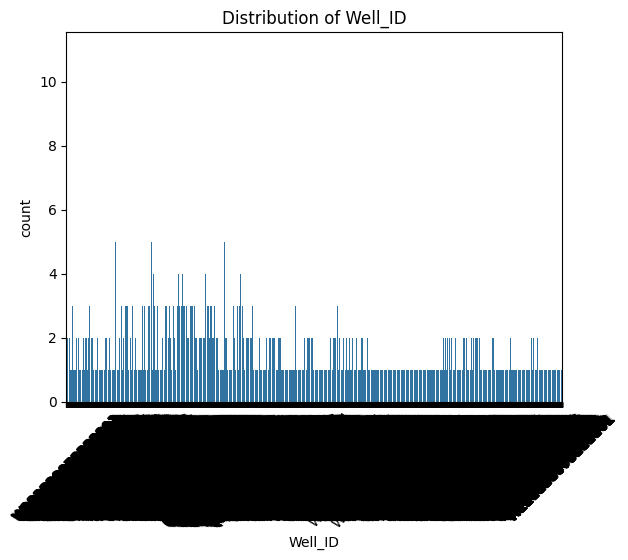

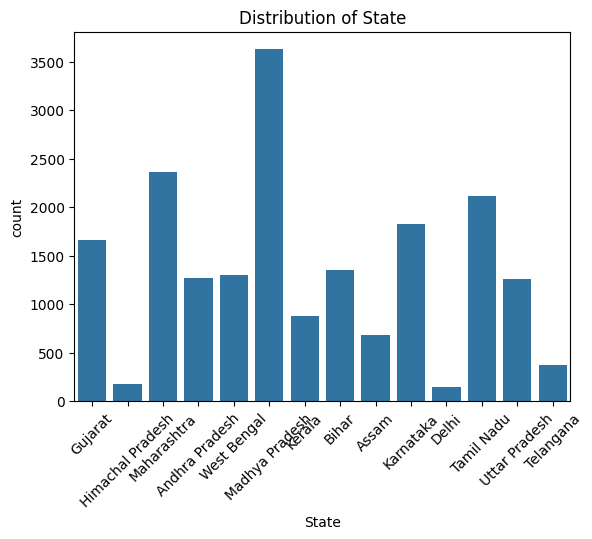

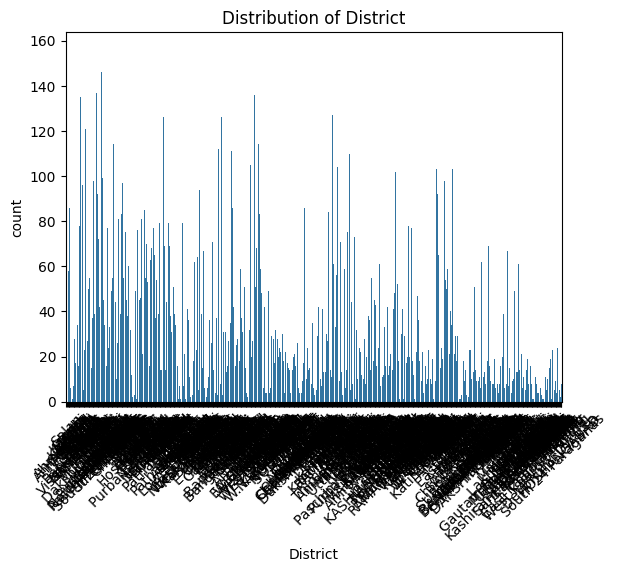

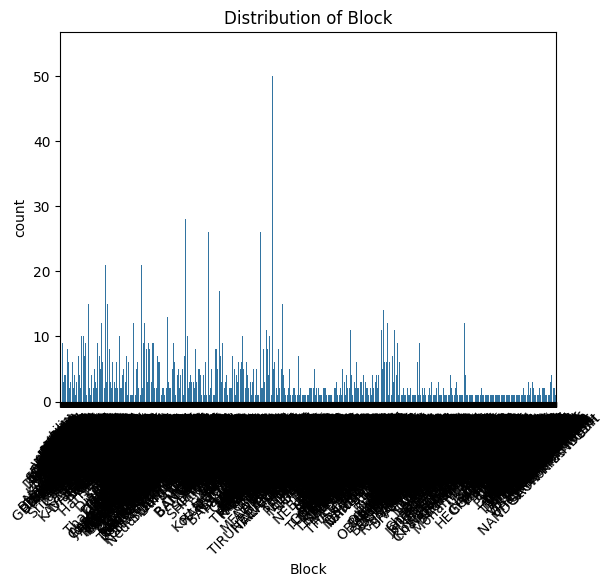

C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

top_features = ['EC', 'Cl', 'TDS', 'Na', 'TH']
for feature in top_features:
    sns.scatterplot(data=df, x=feature, y='WQI')
    plt.title(f"{feature} vs WQI")
    plt.show()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

top_features = ['EC', 'Cl', 'TDS', 'Na', 'TH']
for feature in top_features:
    sns.scatterplot(data=df, x=feature, y='WQI')
    plt.title(f"{feature} vs WQI")
    plt.show()

KeyboardInterrupt: 

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

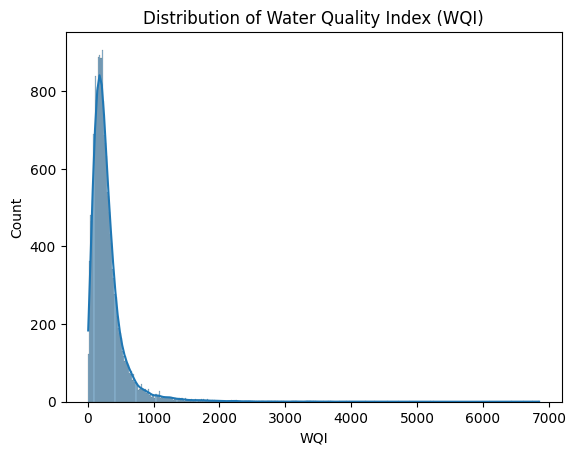

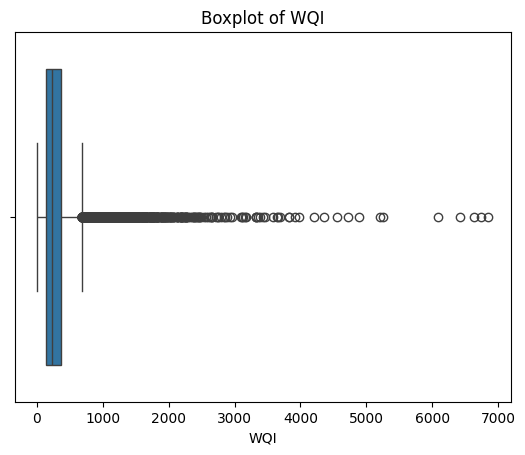

Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


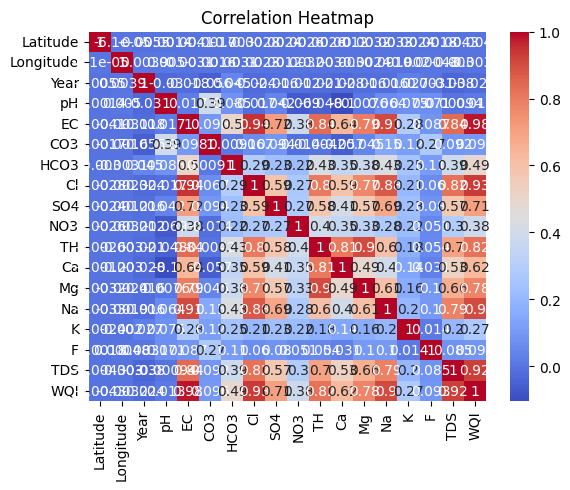

Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


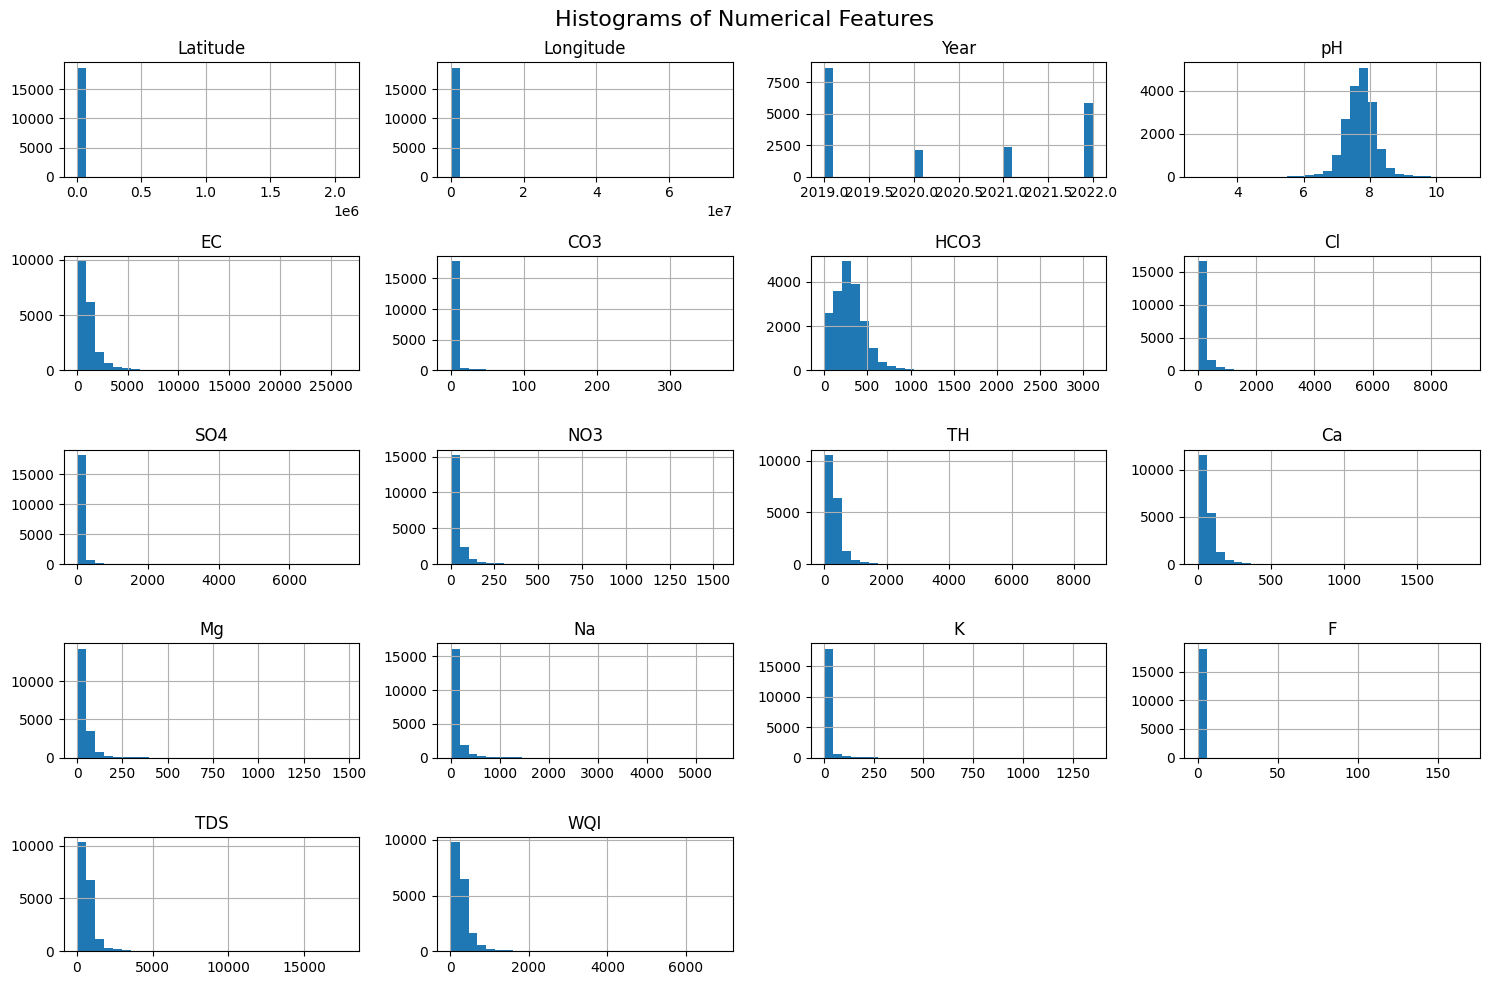

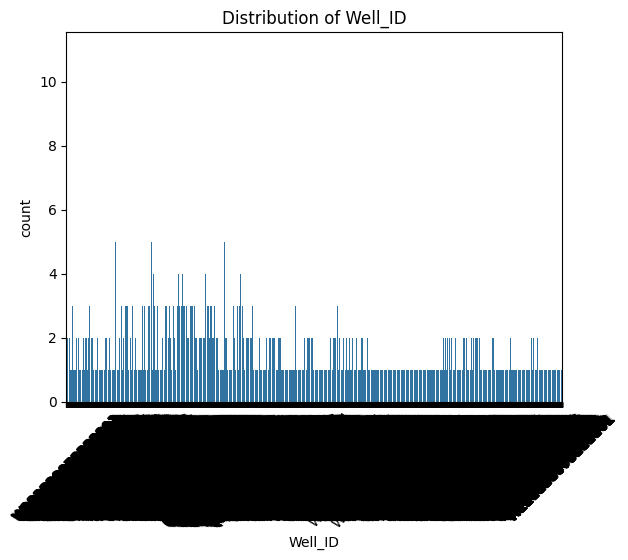

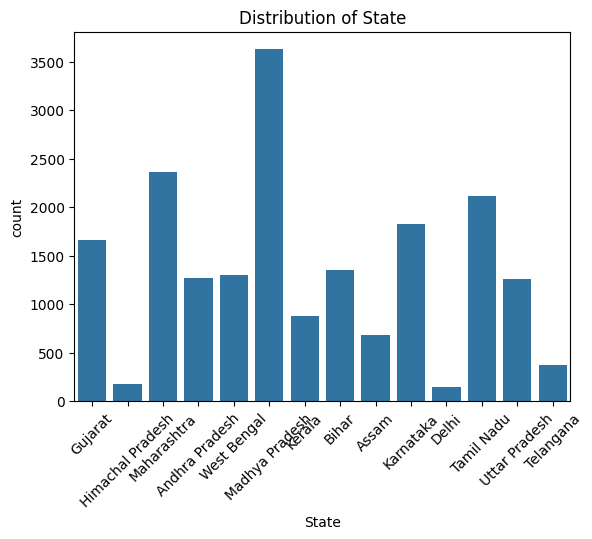

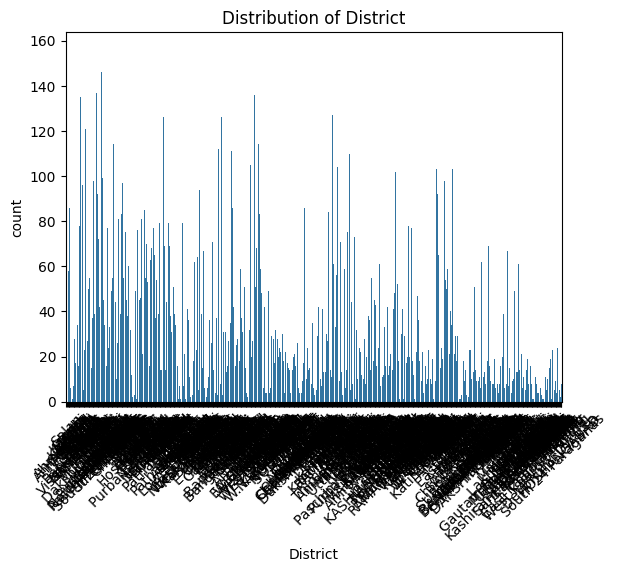

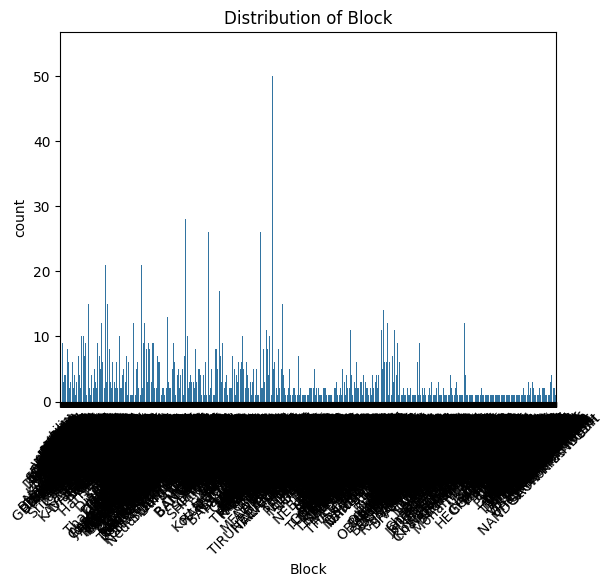

C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython

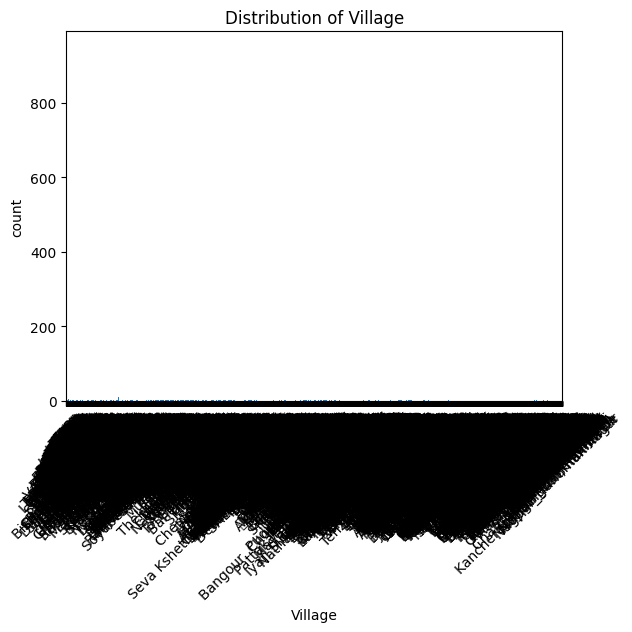

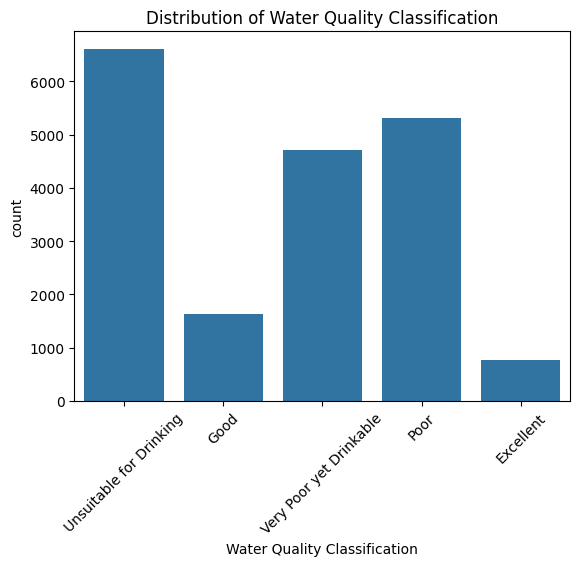

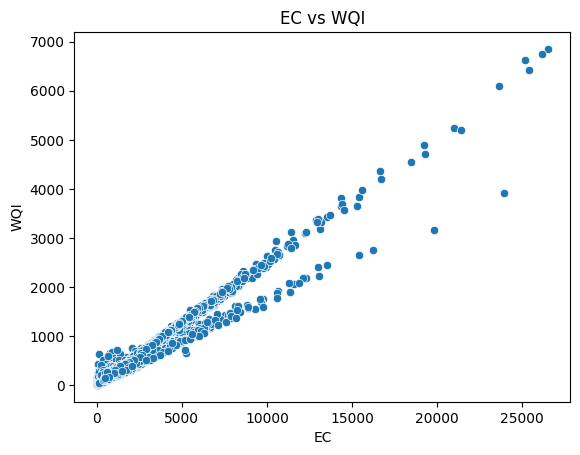

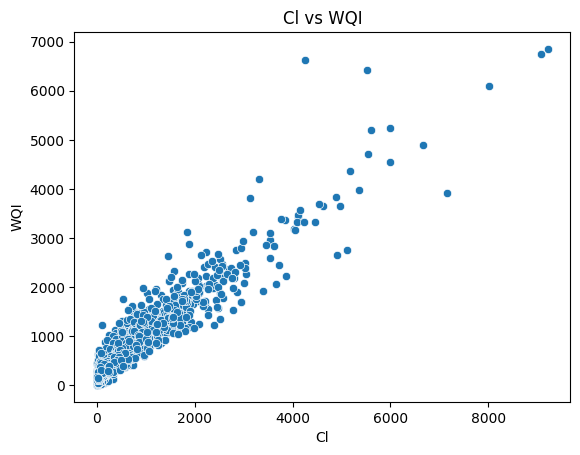

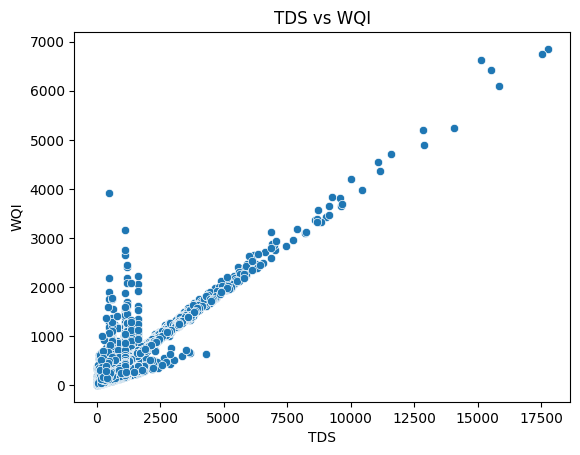

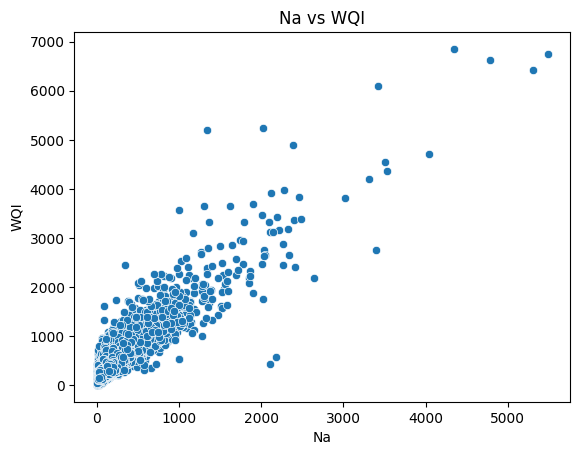

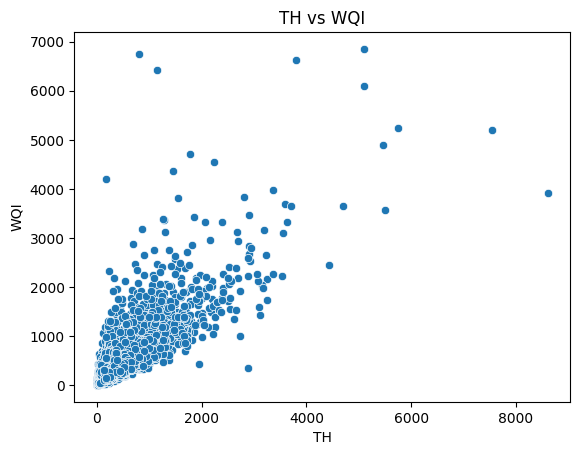

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

top_features = ['EC', 'Cl', 'TDS', 'Na', 'TH']
for feature in top_features:
    sns.scatterplot(data=df, x=feature, y='WQI')
    plt.title(f"{feature} vs WQI")
    plt.show()

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

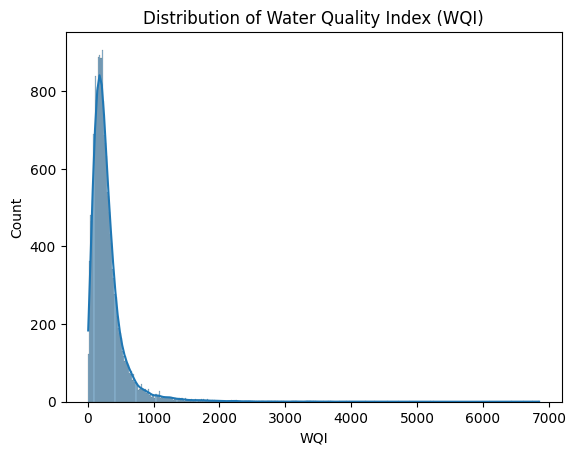

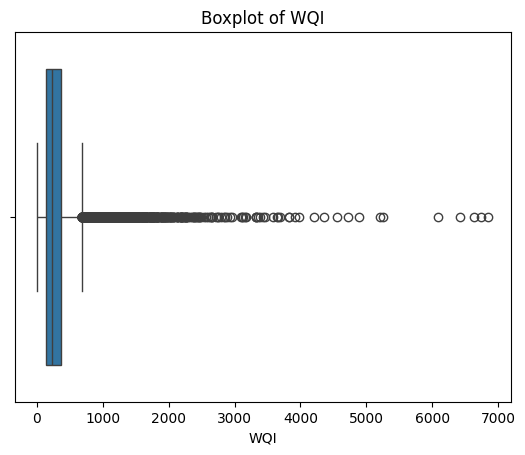

Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


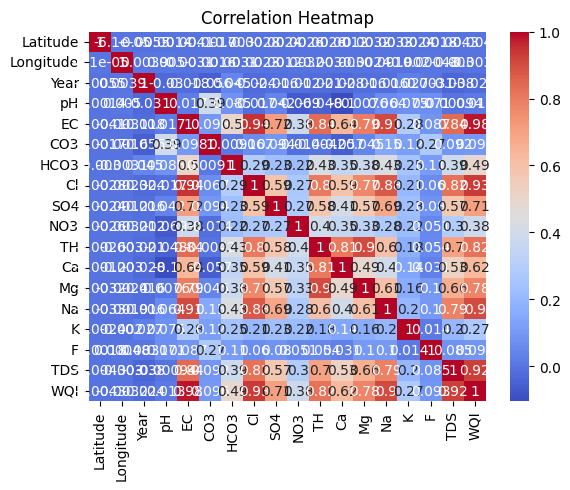

Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


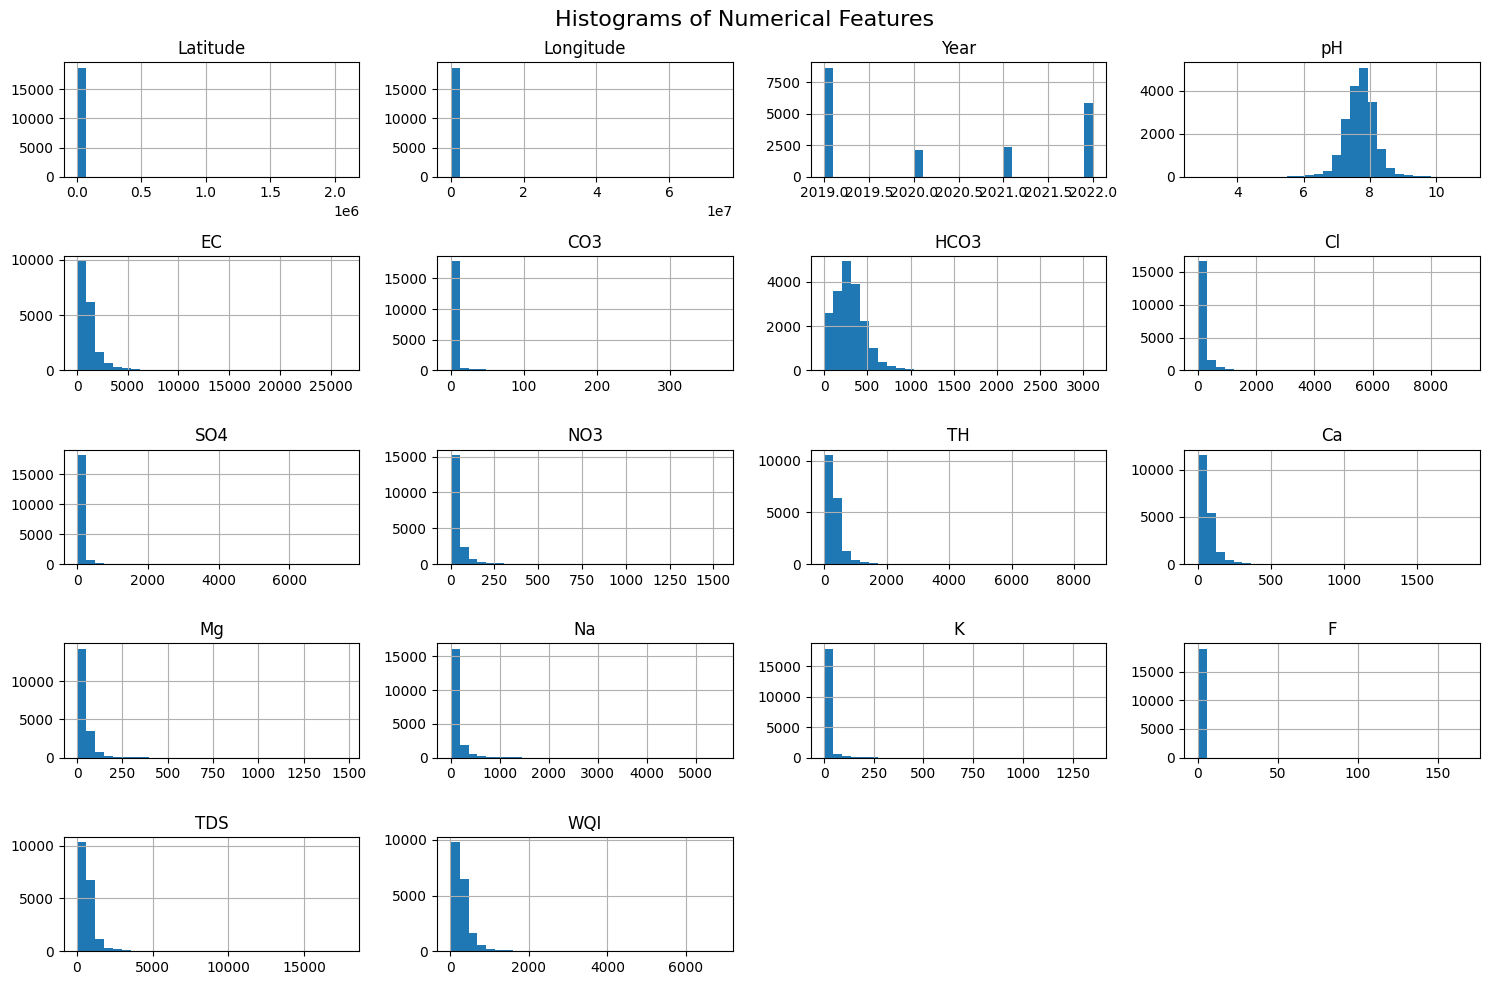

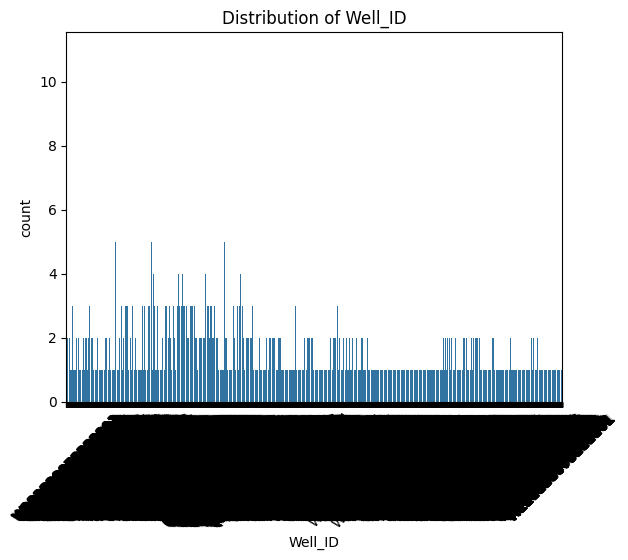

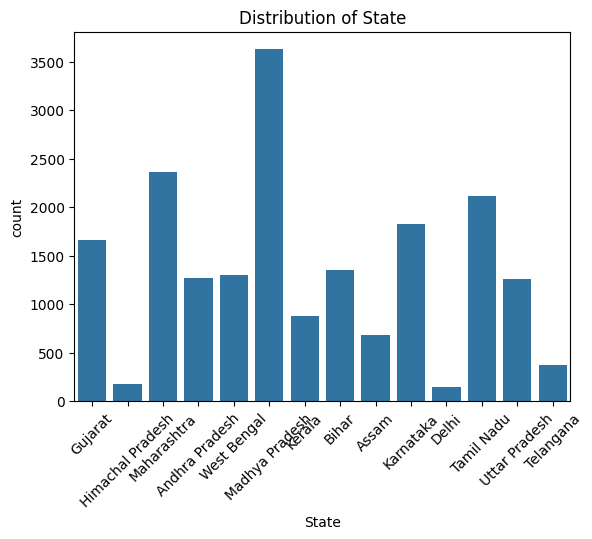

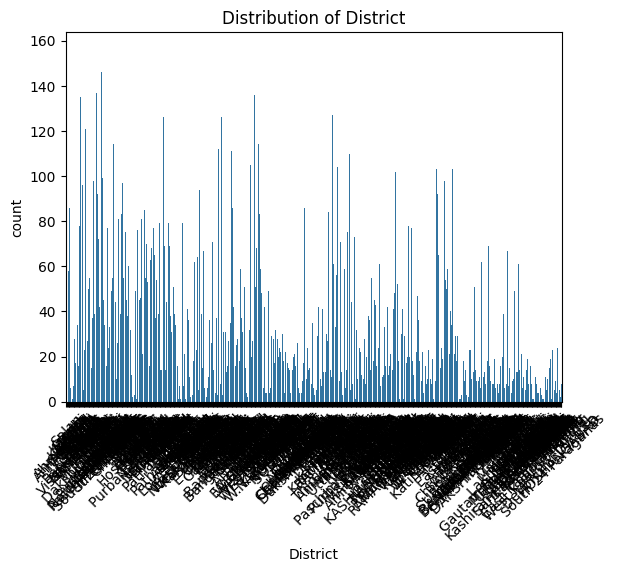

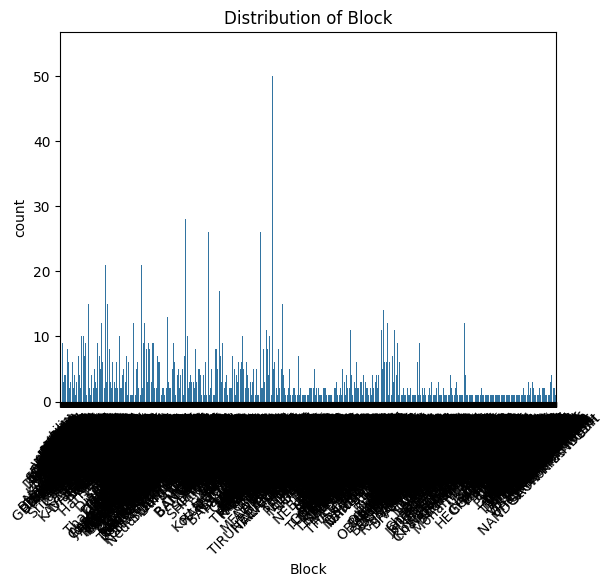

C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rncid\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython

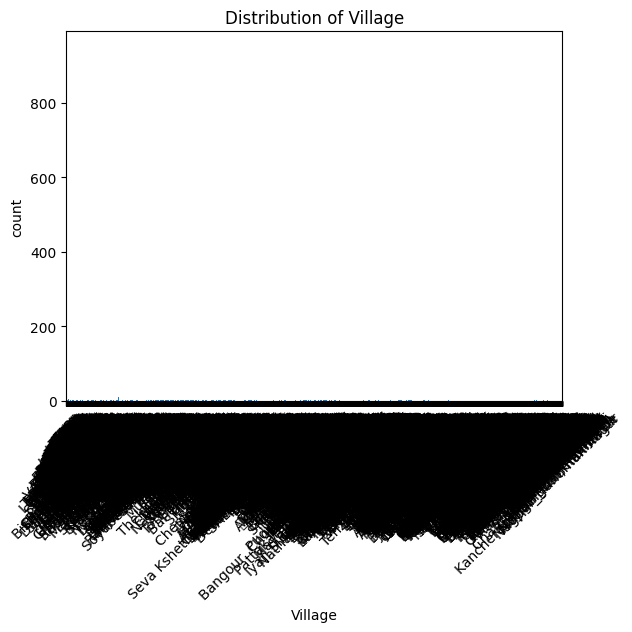

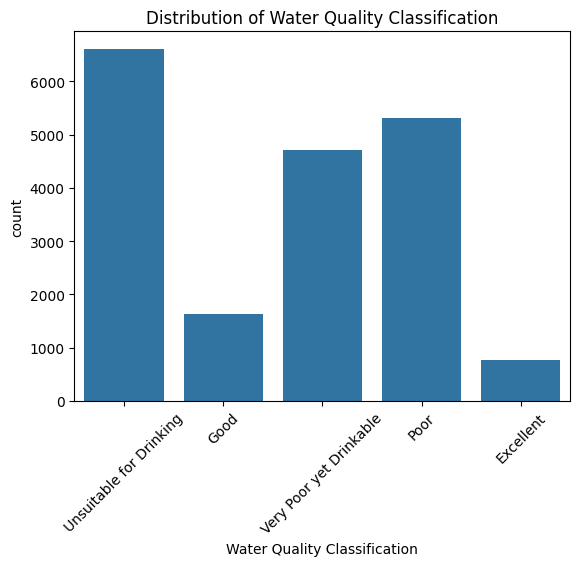

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

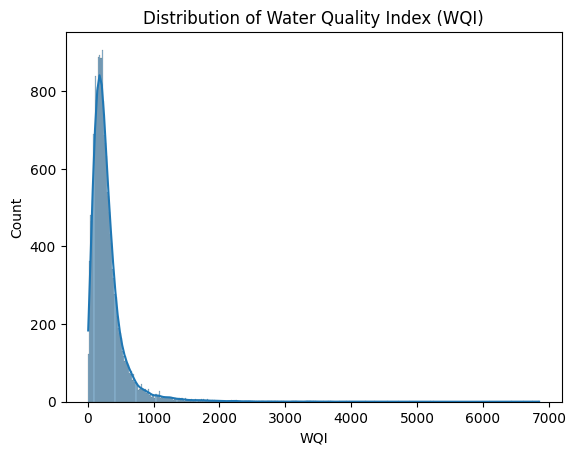

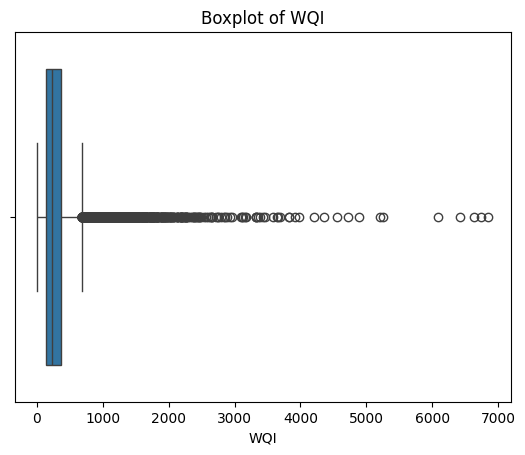

Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


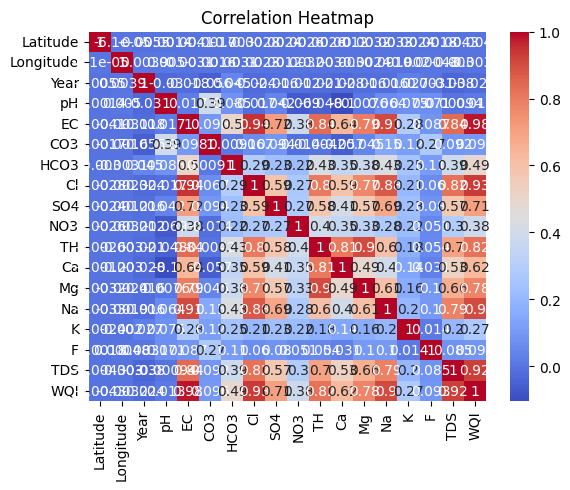

Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


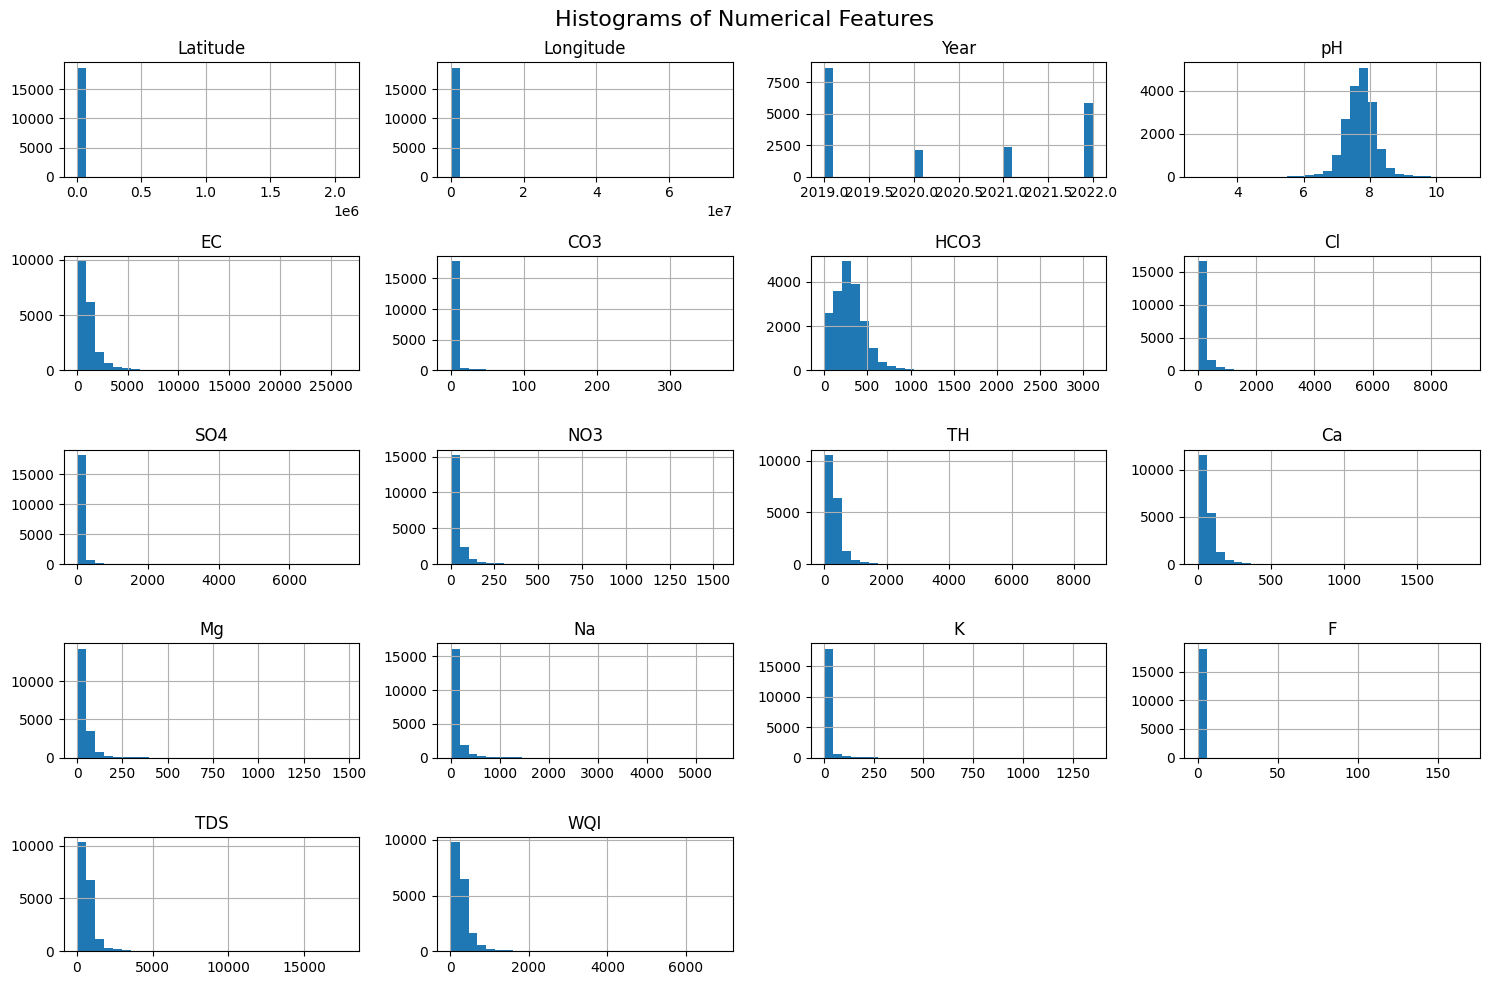

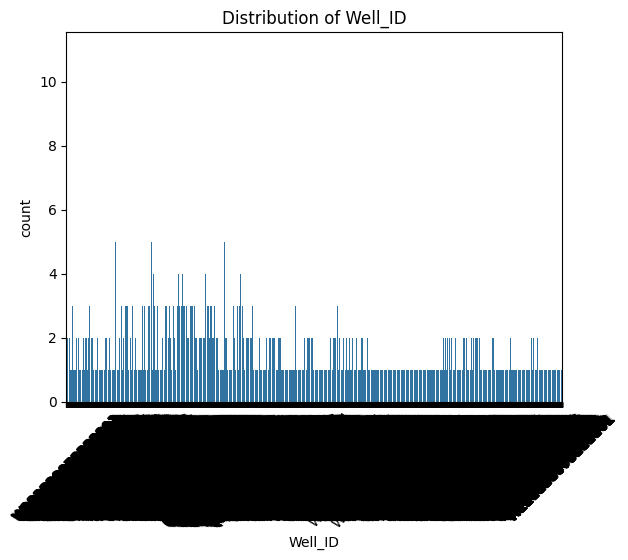

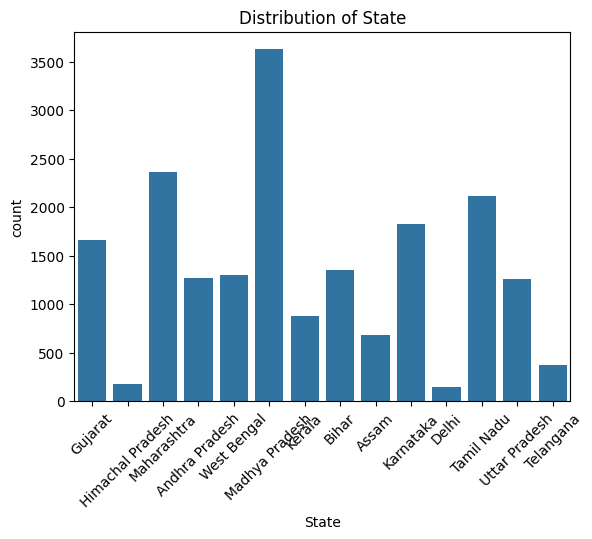

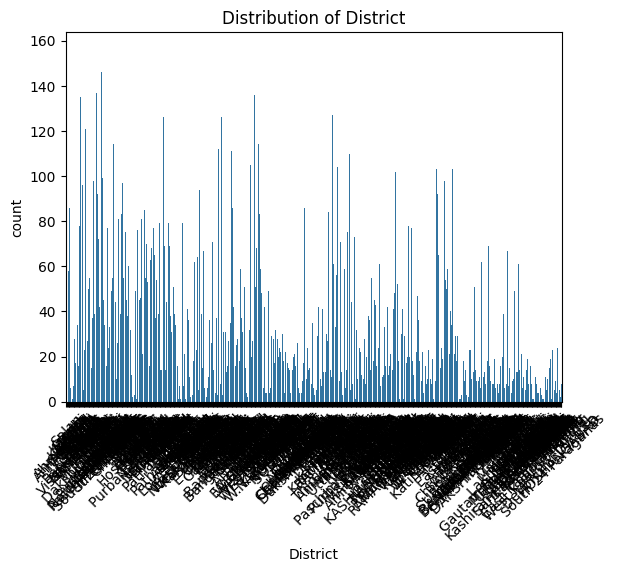

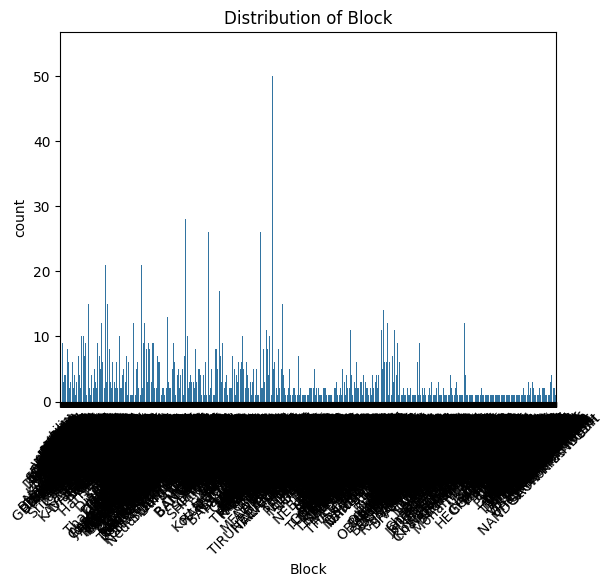

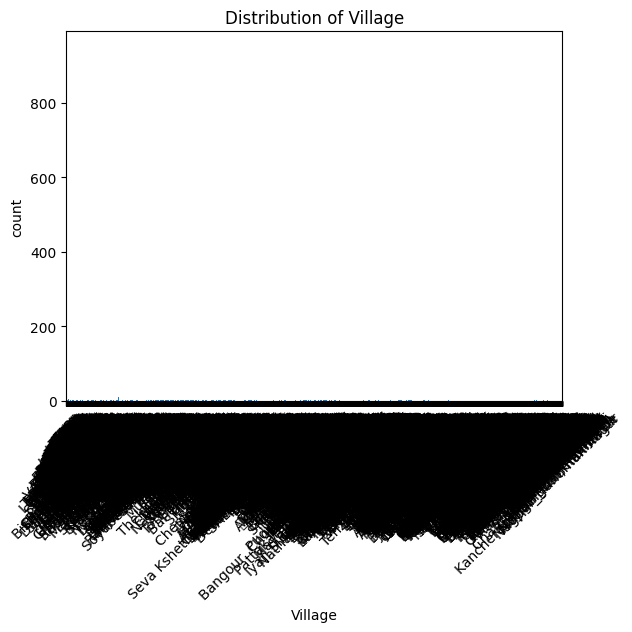

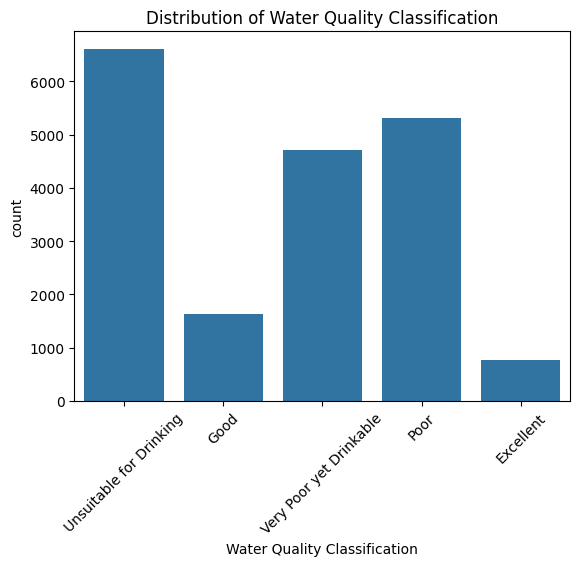

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Replace with your actual file name


# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
df.describe()

# to check if WQI is in the dataset
print(df.columns)  # Make sure 'WQI' is a column

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("Correlation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("Categorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check Identifier Column (Check for columns like id, sample_id, etc.)
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features:
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features:
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

🔹 Shape of dataset: (19029, 24)

🔹 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                 

Latitude     Longitude          Year            pH            EC  \
count  1.864000e+04  1.863900e+04  19029.000000  19029.000000  19029.000000   
mean   1.509049e+02  4.021432e+03   2020.286195      7.713495   1191.620744   
std    1.529204e+04  5.401512e+05      1.314794      0.491413   1348.094278   
min    0.000000e+00  0.000000e+00   2019.000000      2.800000      2.290000   
25%    1.998330e+01  2.522500e+01   2019.000000      7.450000    524.000000   
50%    2.417842e+01  7.617500e+01   2020.000000      7.720000    860.000000   
75%    7.571110e+01  7.953710e+01   2022.000000      8.000000   1390.000000   
max    2.087833e+06  7.374400e+07   2022.000000     10.920000  26520.000000   

                CO3          HCO3            Cl           SO4           NO3  \
count  19029.000000  19029.000000  19029.000000  19029.000000  19029.000000   
mean       3.326689    296.774490    171.843482     68.087940     35.114294   
std       15.496995    180.861685    349.922000    148.853626     55.488528   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000    177.000000     32.000000     13.000000      4.460000   
50%        0.000000    281.000000     78.000000     30.790000     18.000000   
75%        0.000000    390.400000    175.000000     69.000000     43.000000   
max      368.000000   3112.000000   9217.000000   7601.000000   1534.900000   

                 TH            Ca            Mg            Na             K  \
count  19029.000000  19029.000000  19029.000000  19029.000000  19029.000000   
mean     327.843466     65.114035     40.505256    113.673866     13.465496   
std      310.386082     62.018322     49.654295    200.551600     38.839328   
min        3.000000      0.000000      0.000000      0.000000      0.000000   
25%      165.000000     28.100000     15.000000     28.000000      1.700000   
50%      260.000000     50.100000     29.000000     60.400000      3.630000   
75%      400.000000     80.000000     49.800000    121.000000      9.510000   
max     8606.880000   1840.000000   1483.500000   5489.000000   1353.000000   

                  F           TDS           WQI  
count  19029.000000  19029.000000  19029.000000  
mean       0.595598    723.774239    305.291789  
std        1.818577    755.575601    315.477116  
min       -0.160000     15.000000      9.043604  
25%        0.206000    345.000000    146.642420  
50%        0.430000    587.000000    232.078880  
75%        0.770000    913.000000    359.718240  
max      168.000000  17768.000000   6850.888720


🔹 Missing Values:
Well_ID                         3785
Block                           1119
Longitude                        390
Latitude                         389
Village                            1
State                              0
District                           0
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64


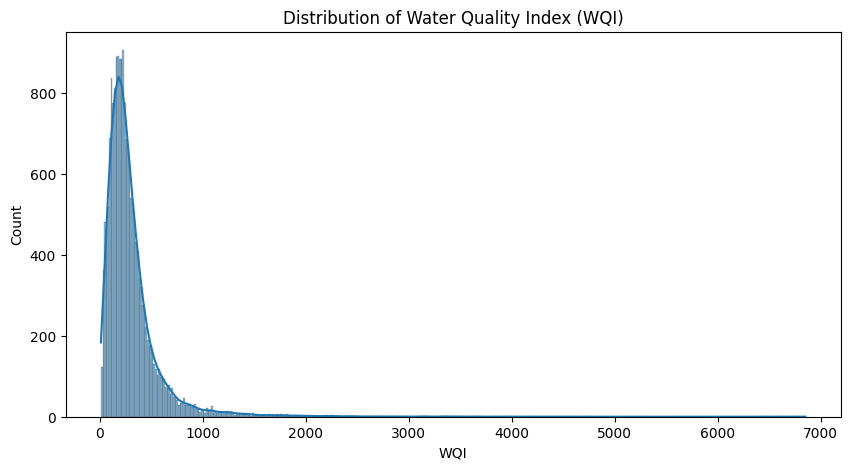

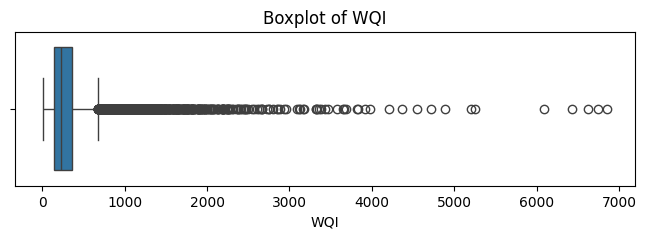

🔹 Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


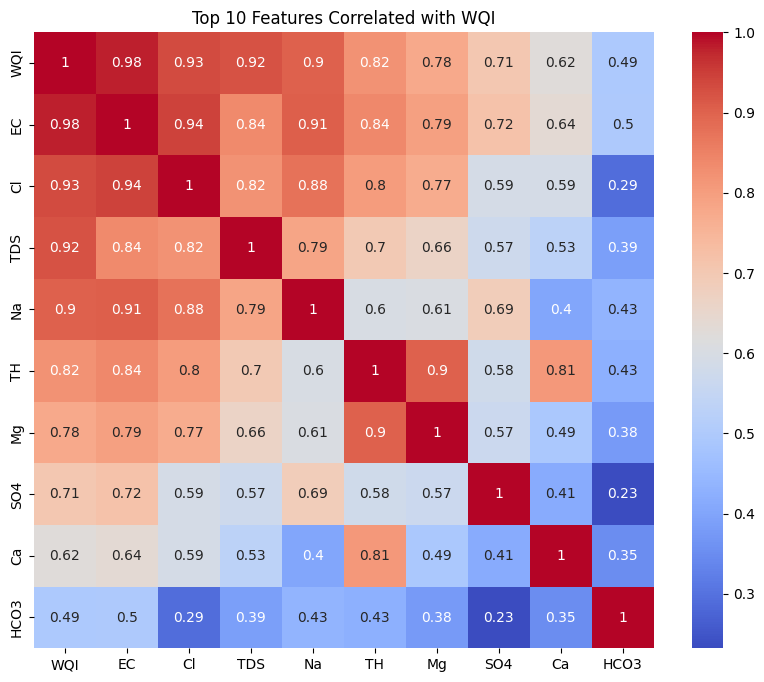

🔹 Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
🔹 Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']

🔹 Possible Identifier Columns:

🔹 Skewness of Numerical Features:
Latitude     136.527697
Longitude    136.524427
F             82.137070
SO4           14.000478
K             10.651684
Cl             8.705773
Na             8.568633
CO3            8.054655
Mg             7.869428
TDS            6.840064
WQI            6.206578
TH             5.944961
EC             5.813054
NO3            5.576974
Ca             5.020718
HCO3           1.441357
Year           0.274635
pH            -0.996603
dtype: float64

🔹 Plotting Histograms of Numerical Features...


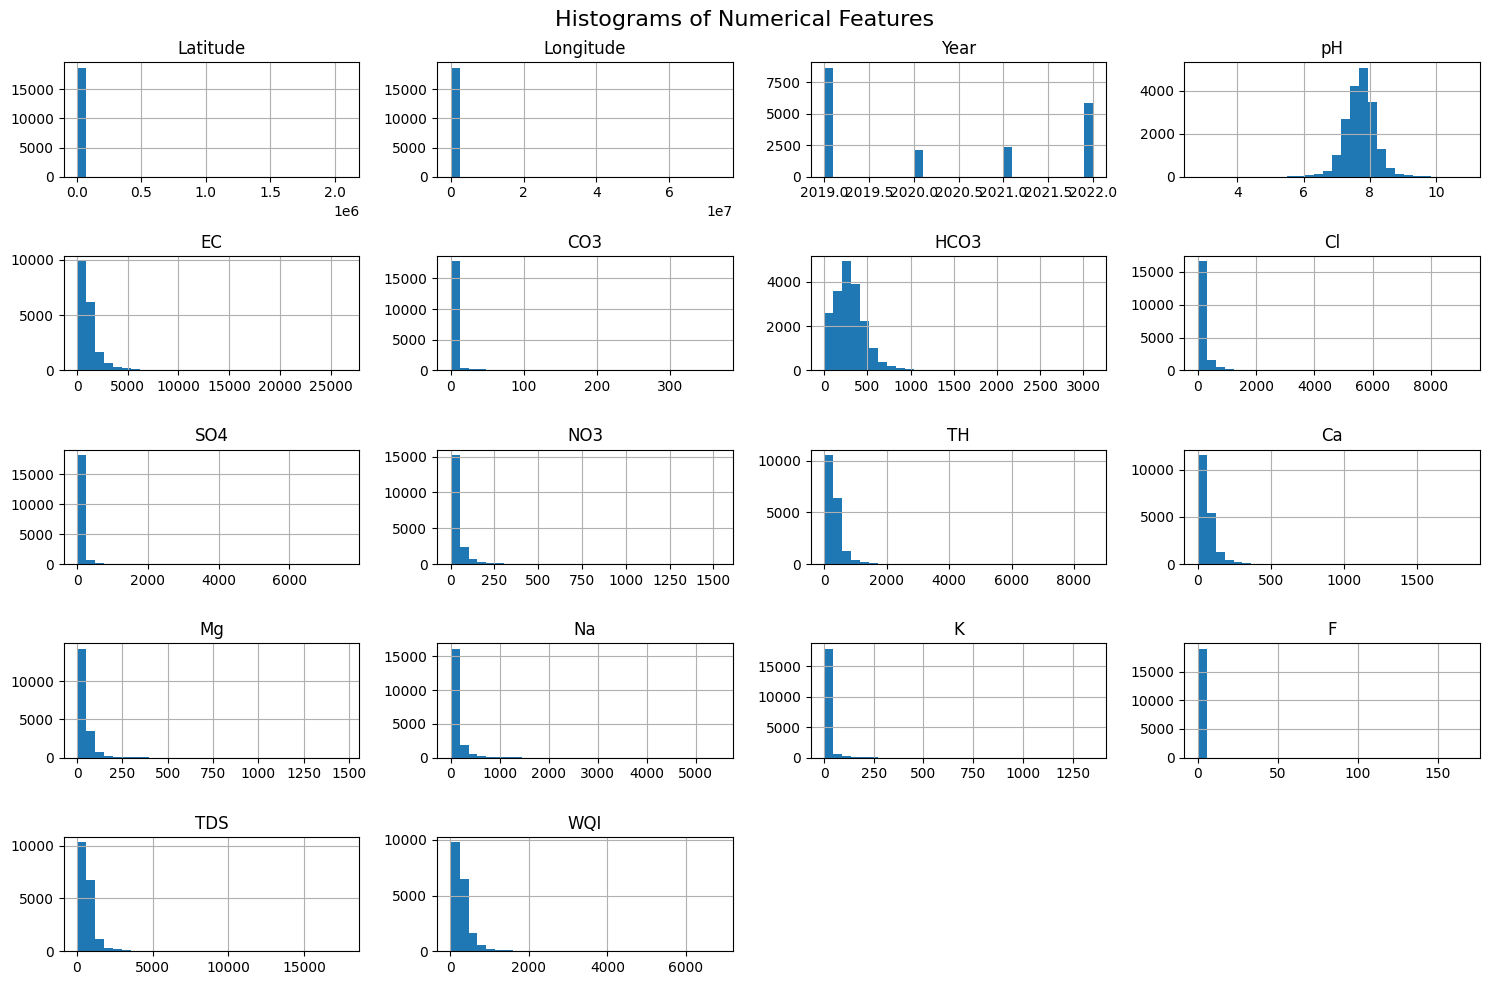


🔹 Plotting Count Plots for Categorical Features...


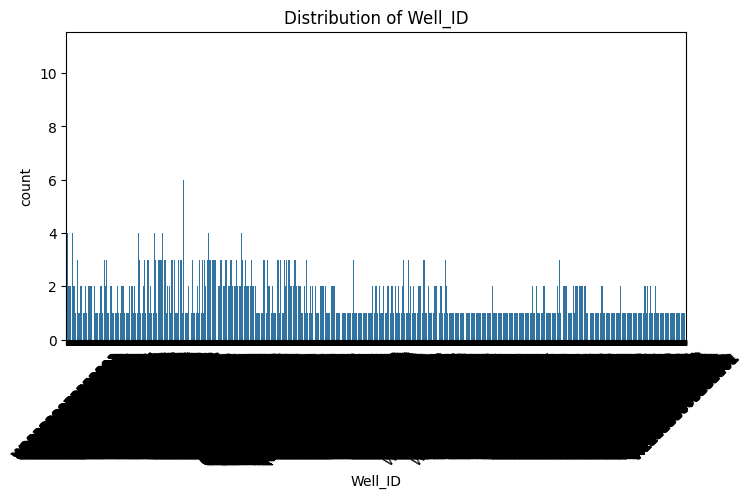

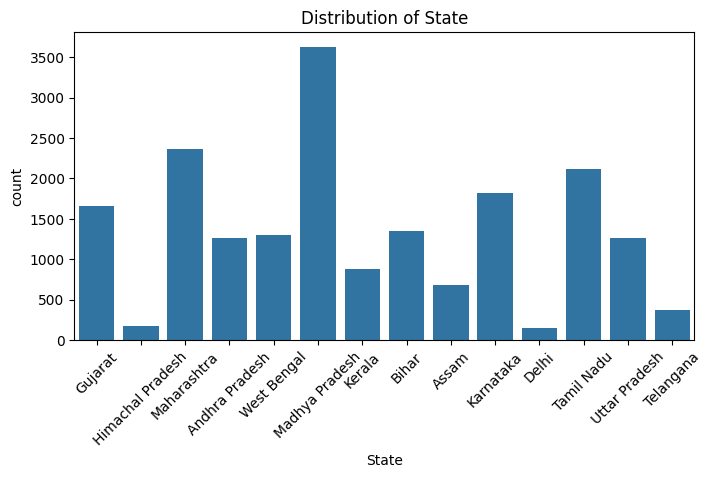

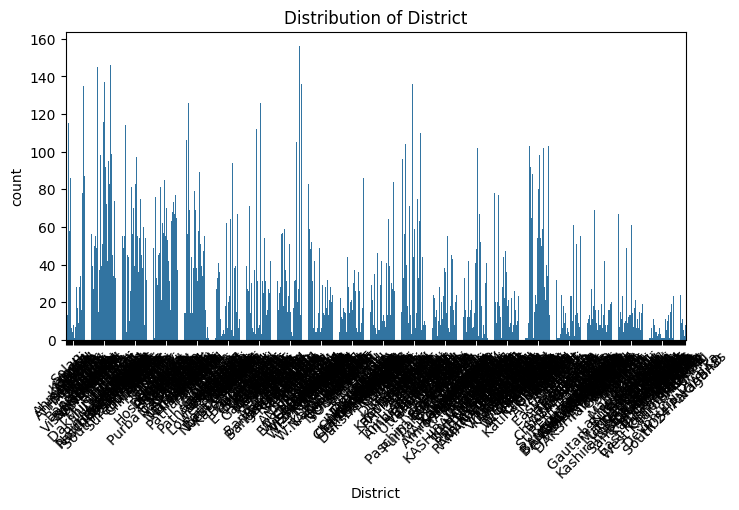

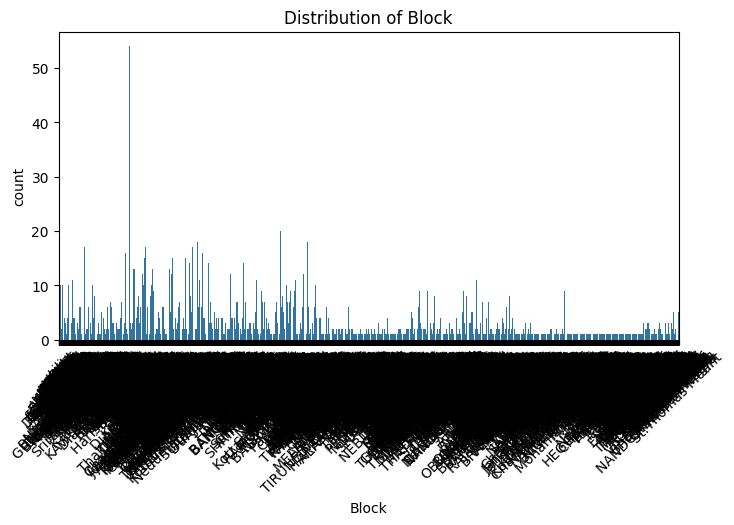

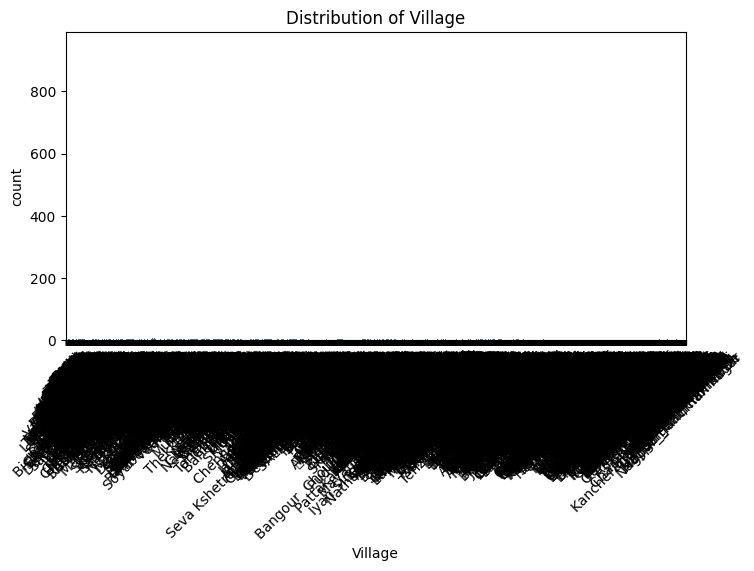

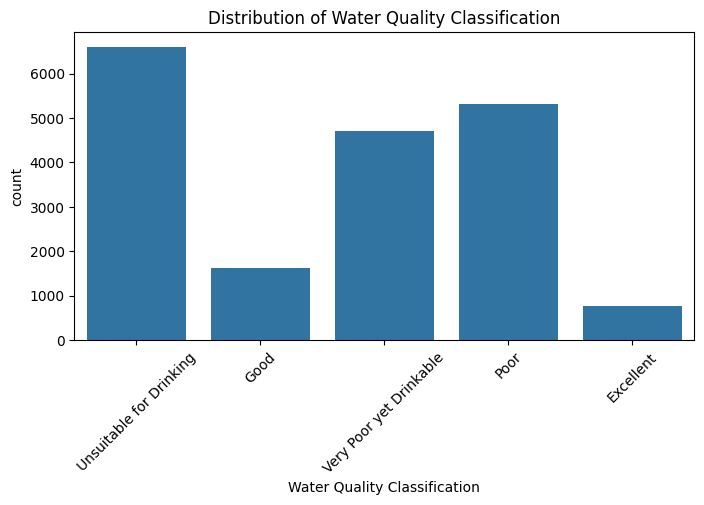

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ------------------------------
# Function Definitions
# ------------------------------

def show_basic_info(df):
    print("🔹 Shape of dataset:", df.shape)
    print("\n🔹 Info:")
    df.info()
    print("\n🔹 Summary Statistics:")
    display(df.describe())

def show_missing_values(df):
    print("\n🔹 Missing Values:")
    print(df.isnull().sum().sort_values(ascending=False))

def plot_wqi_distribution(df):
    if 'WQI' in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df['WQI'], kde=True)
        plt.title("Distribution of Water Quality Index (WQI)")
        plt.xlabel("WQI")
        plt.show()

        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df['WQI'])
        plt.title("Boxplot of WQI")
        plt.show()
    else:
        print("WQI not found in dataset.")

def correlation_analysis(df):
    correlation = df.corr(numeric_only=True)
    if 'WQI' in correlation.columns:
        wqi_corr = correlation['WQI'].sort_values(ascending=False)
        print("🔹 Correlation with WQI:")
        print(wqi_corr)

        # Heatmap for top 10 correlated features with WQI
        top_corr = wqi_corr.abs().sort_values(ascending=False).head(10).index
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[top_corr].corr(), annot=True, cmap="coolwarm")
        plt.title("Top 10 Features Correlated with WQI")
        plt.show()
    else:
        print("WQI column not found in correlation matrix.")

def identify_column_types(df):
    categorical = df.select_dtypes(include='object').columns.tolist()
    numerical = df.select_dtypes(include='number').columns.tolist()
    print("🔹 Categorical Columns:", categorical)
    print("🔹 Numerical Columns:", numerical)
    return categorical, numerical

def detect_identifier_columns(df):
    print("\n🔹 Possible Identifier Columns:")
    for col in df.columns:
        if df[col].is_unique:
            print(f"  ➤ {col} is likely an identifier column.")

def show_skewness(df, numerical):
    print("\n🔹 Skewness of Numerical Features:")
    print(df[numerical].skew().sort_values(ascending=False))

def plot_distributions(df, numerical, categorical):
    print("\n🔹 Plotting Histograms of Numerical Features...")
    df[numerical].hist(figsize=(15, 10), bins=30)
    plt.suptitle("Histograms of Numerical Features", fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n🔹 Plotting Count Plots for Categorical Features...")
    for col in categorical:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, data=df)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()

# ------------------------------
# Main Execution
# ------------------------------

# Load Dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# Run EDA Pipeline
show_basic_info(df)
show_missing_values(df)
plot_wqi_distribution(df)
correlation_analysis(df)
categorical, numerical = identify_column_types(df)
detect_identifier_columns(df)
show_skewness(df, numerical)
plot_distributions(df, numerical, categorical)


Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

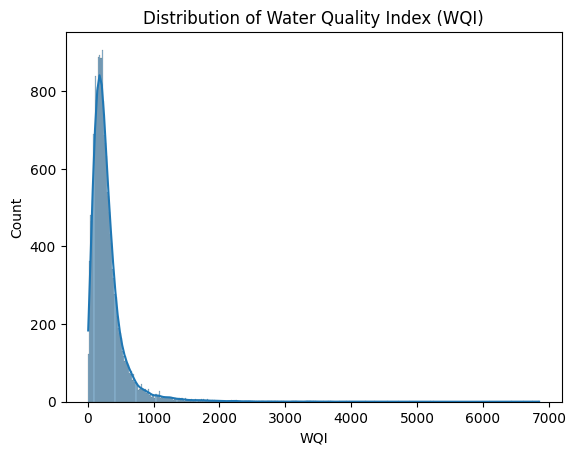

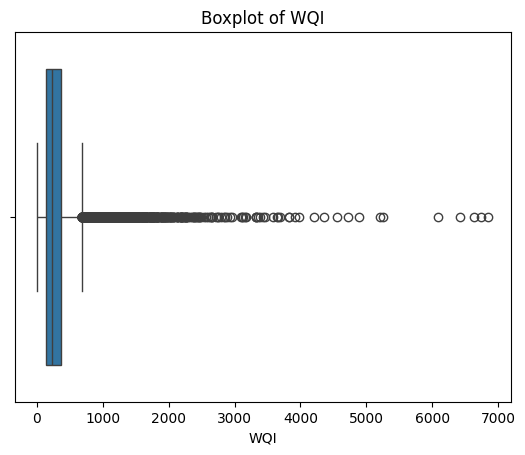


Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


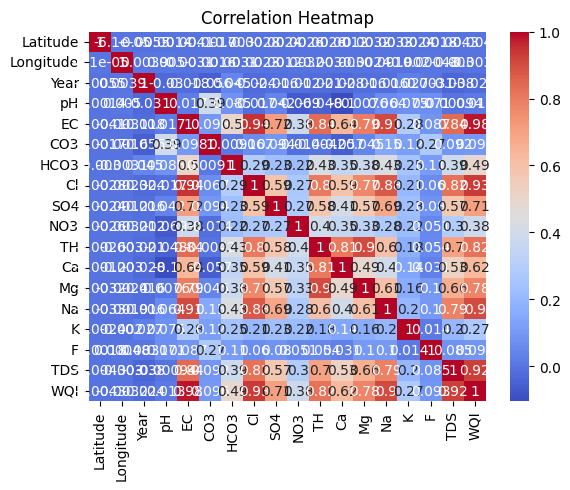


Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


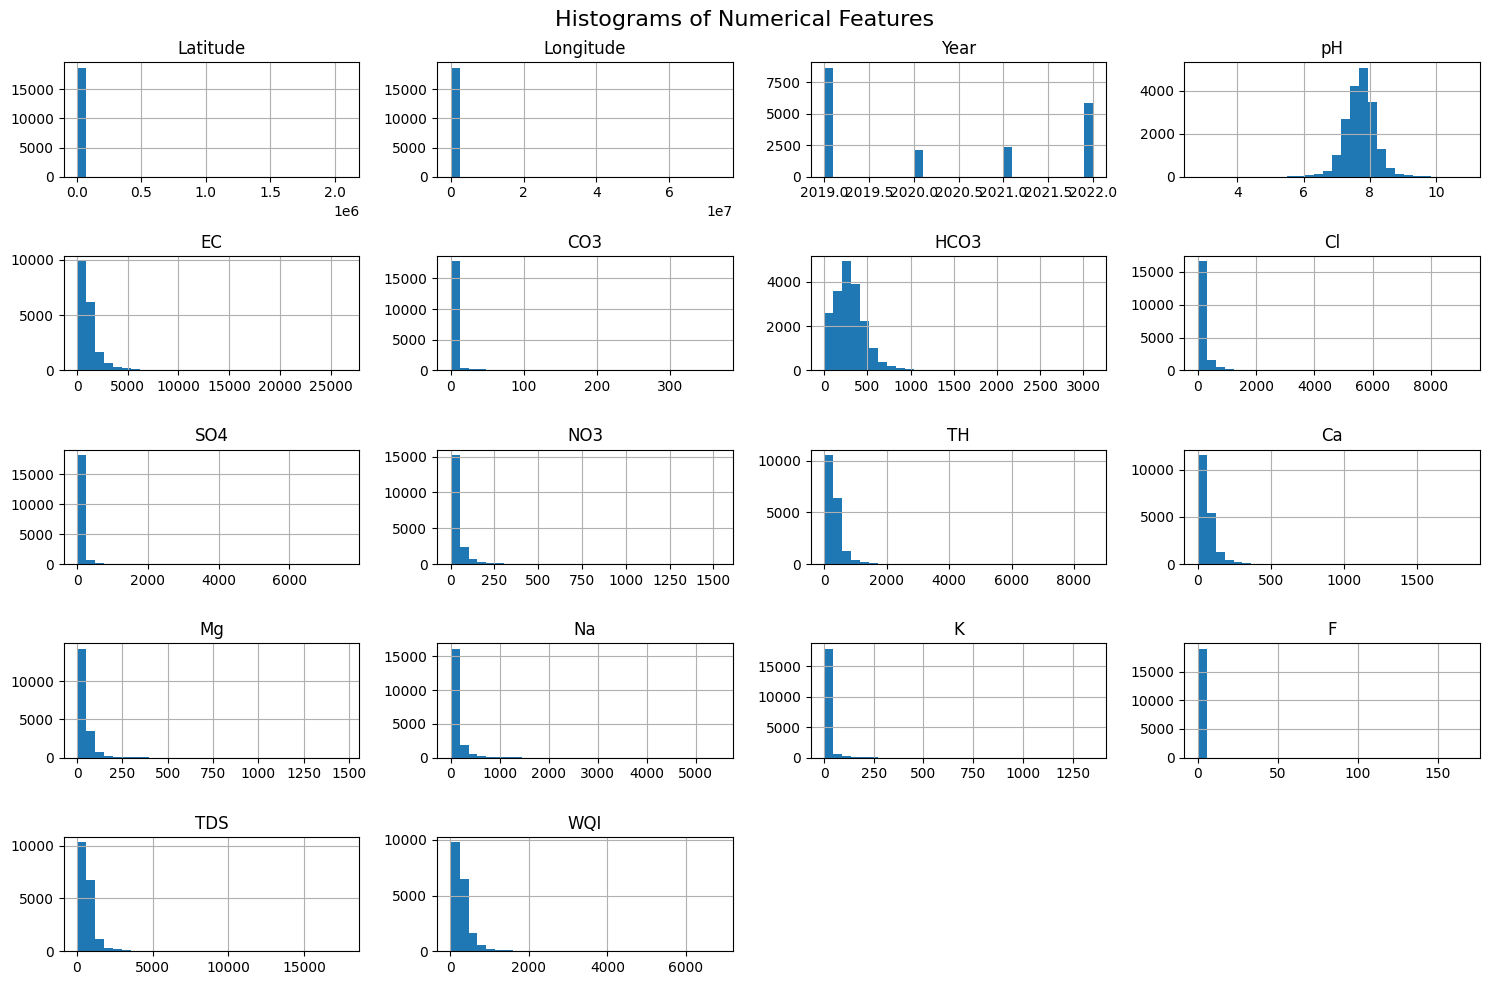

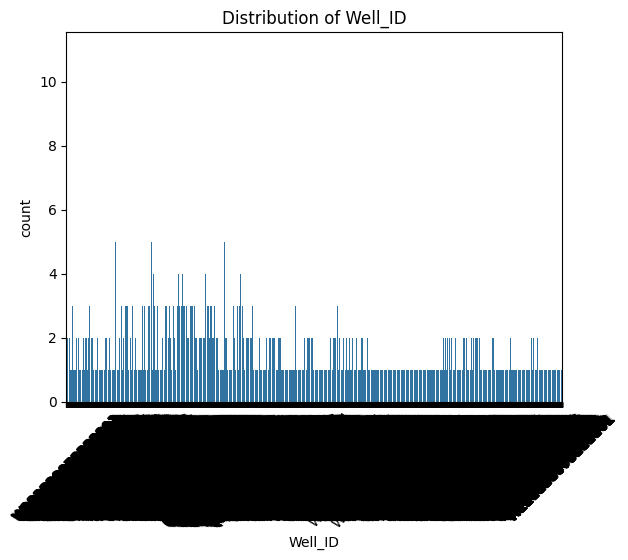

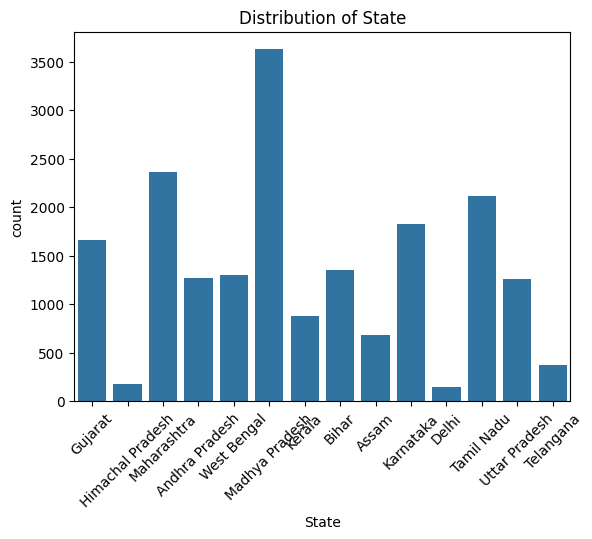

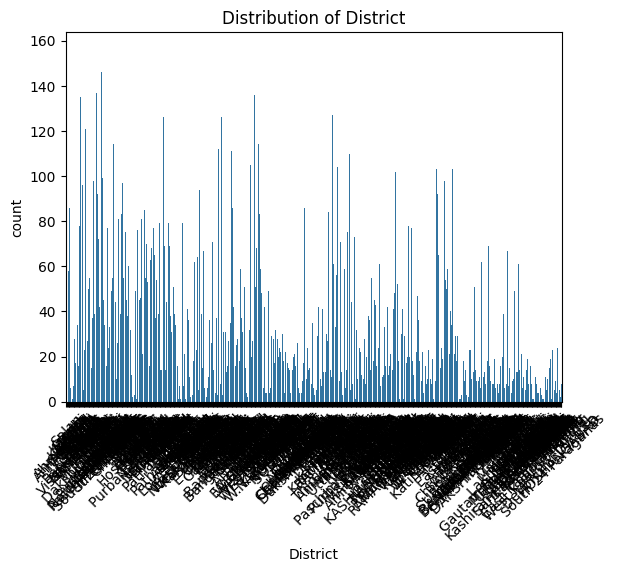

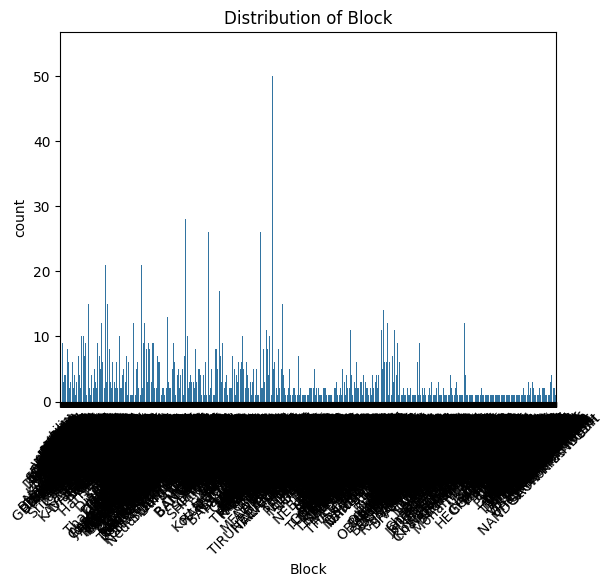

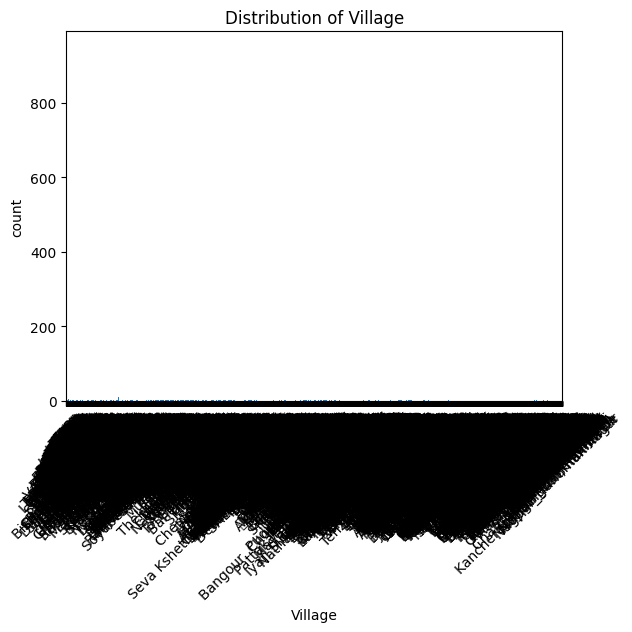

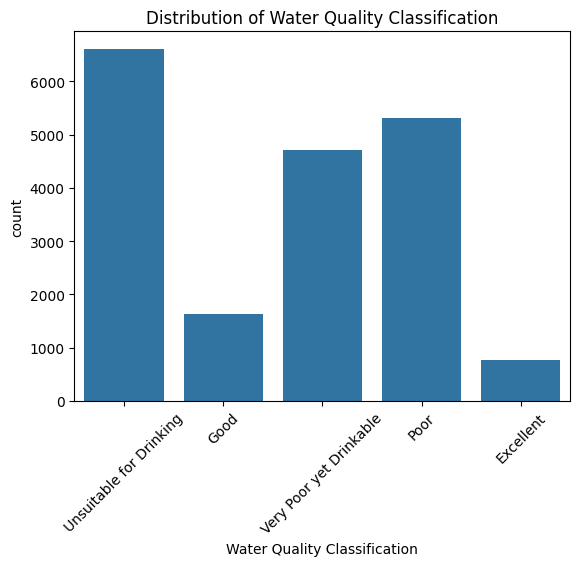


[Preprocessing Step Started]
Missing values before:
 Well_ID                         3785
State                              0
District                           0
Block                           1119
Village                            1
Latitude                         389
Longitude                        390
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64
Missing values after:
 Well_ID               

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# Check if WQI is in the dataset
print("\nColumns in dataset:")
print(df.columns)  # Ensure 'WQI' exists

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("\nCorrelation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\nCategorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check for Identifier Columns
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# ================================
# 🔧 Preprocessing Before Modeling
# ================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("\n[Preprocessing Step Started]")

# Step 1: Handle Missing Values
print("Missing values before:\n", df.isnull().sum())
df = df.dropna()  # or you can use df.fillna(method='ffill') or df.fillna(df.mean())
print("Missing values after:\n", df.isnull().sum())

# Step 2: Encode Categorical Features
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 3: Scale Numerical Features
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

# Step 4: Prepare X and y
if 'WQI' in df.columns:
    X = df.drop("WQI", axis=1)
    y = df["WQI"]

    # Step 5: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training and testing data prepared.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
else:
    print("WQI not found. Please check column names.")

# ================================
# End of Script
# ================================


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Adjust the path if needed

# --- CLASS DISTRIBUTION ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Water_Quality", palette="Set2", order=df["WaterQualityClassification"].value_counts().index)
plt.title("Class Distribution of Water Quality", fontsize=14)
plt.xlabel("Water Quality Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- NUMERICAL FEATURE DISTRIBUTIONS ---
numerical_cols = df.select_dtypes(include="number").columns.tolist()

df[numerical_cols].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# --- BOXPLOTS TO DETECT OUTLIERS ---
for col in numerical_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# --- HEATMAP OF FEATURE CORRELATIONS ---
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# --- CORRELATION WITH WQI (IF INCLUDED) ---
if 'WQI' in df.columns:
    print("Top Correlations with WQI:")
    wqi_corr = correlation_matrix['WQI'].sort_values(ascending=False)
    print(wqi_corr)

    # WQI distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df['WQI'], kde=True, color="purple")
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.tight_layout()
    plt.show()

    # Boxplot of WQI
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x='WQI', data=df, color="violet")
    plt.title("Boxplot of WQI")
    plt.tight_layout()
    plt.show()


KeyError: 'Water_Quality'

<Figure size 800x500 with 0 Axes>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Adjust the path if needed

# --- CLASS DISTRIBUTION ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Water_Quality", palette="Set2", order=df["WaterQualityClassification"].value_counts().index)
plt.title("Class Distribution of Water Quality", fontsize=14)
plt.xlabel("Water Quality Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- NUMERICAL FEATURE DISTRIBUTIONS ---
numerical_cols = df.select_dtypes(include="number").columns.tolist()

df[numerical_cols].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# --- BOXPLOTS TO DETECT OUTLIERS ---
for col in numerical_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# --- HEATMAP OF FEATURE CORRELATIONS ---
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# --- CORRELATION WITH WQI (IF INCLUDED) ---
if 'WQI' in df.columns:
    print("Top Correlations with WQI:")
    wqi_corr = correlation_matrix['WQI'].sort_values(ascending=False)
    print(wqi_corr)

    # WQI distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df['WQI'], kde=True, color="purple")
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.tight_layout()
    plt.show()

    # Boxplot of WQI
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x='WQI', data=df, color="violet")
    plt.title("Boxplot of WQI")
    plt.tight_layout()
    plt.show()


KeyError: 'WaterQualityClassification'

<Figure size 800x500 with 0 Axes>

In [4]:
print("Available columns:")
print(df.columns.tolist())



Available columns:
['Well_ID', 'State', 'District', 'Block', 'Village', 'Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI', 'Water Quality Classification']


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")  # Adjust the path if needed

# --- CLASS DISTRIBUTION ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Water_Quality", palette="Set2", order=df["Water Quality Classification"].value_counts().index)
plt.title("Class Distribution of Water Quality", fontsize=14)
plt.xlabel("Water Quality Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- NUMERICAL FEATURE DISTRIBUTIONS ---
numerical_cols = df.select_dtypes(include="number").columns.tolist()

df[numerical_cols].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# --- BOXPLOTS TO DETECT OUTLIERS ---
for col in numerical_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# --- HEATMAP OF FEATURE CORRELATIONS ---
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# --- CORRELATION WITH WQI (IF INCLUDED) ---
if 'WQI' in df.columns:
    print("Top Correlations with WQI:")
    wqi_corr = correlation_matrix['WQI'].sort_values(ascending=False)
    print(wqi_corr)

    # WQI distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df['WQI'], kde=True, color="purple")
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.tight_layout()
    plt.show()

    # Boxplot of WQI
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x='WQI', data=df, color="violet")
    plt.title("Boxplot of WQI")
    plt.tight_layout()
    plt.show()

ValueError: Could not interpret value `Water_Quality` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

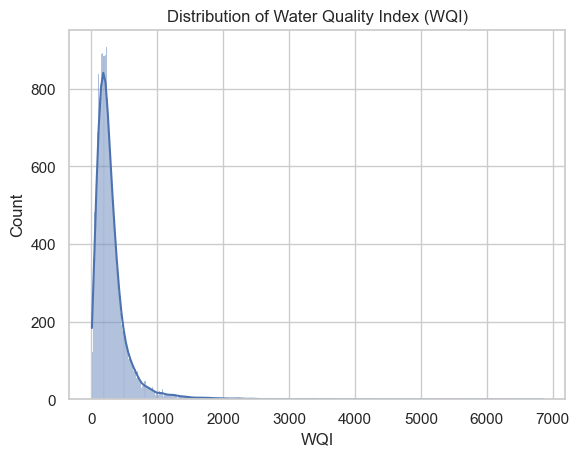

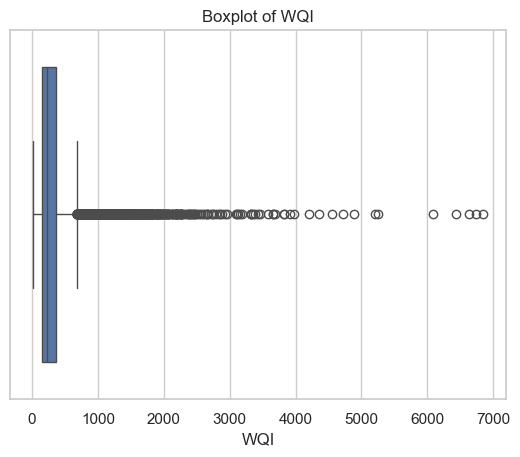


Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


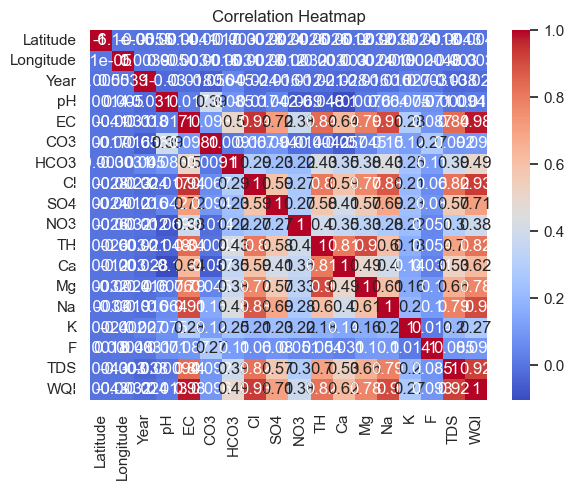


Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


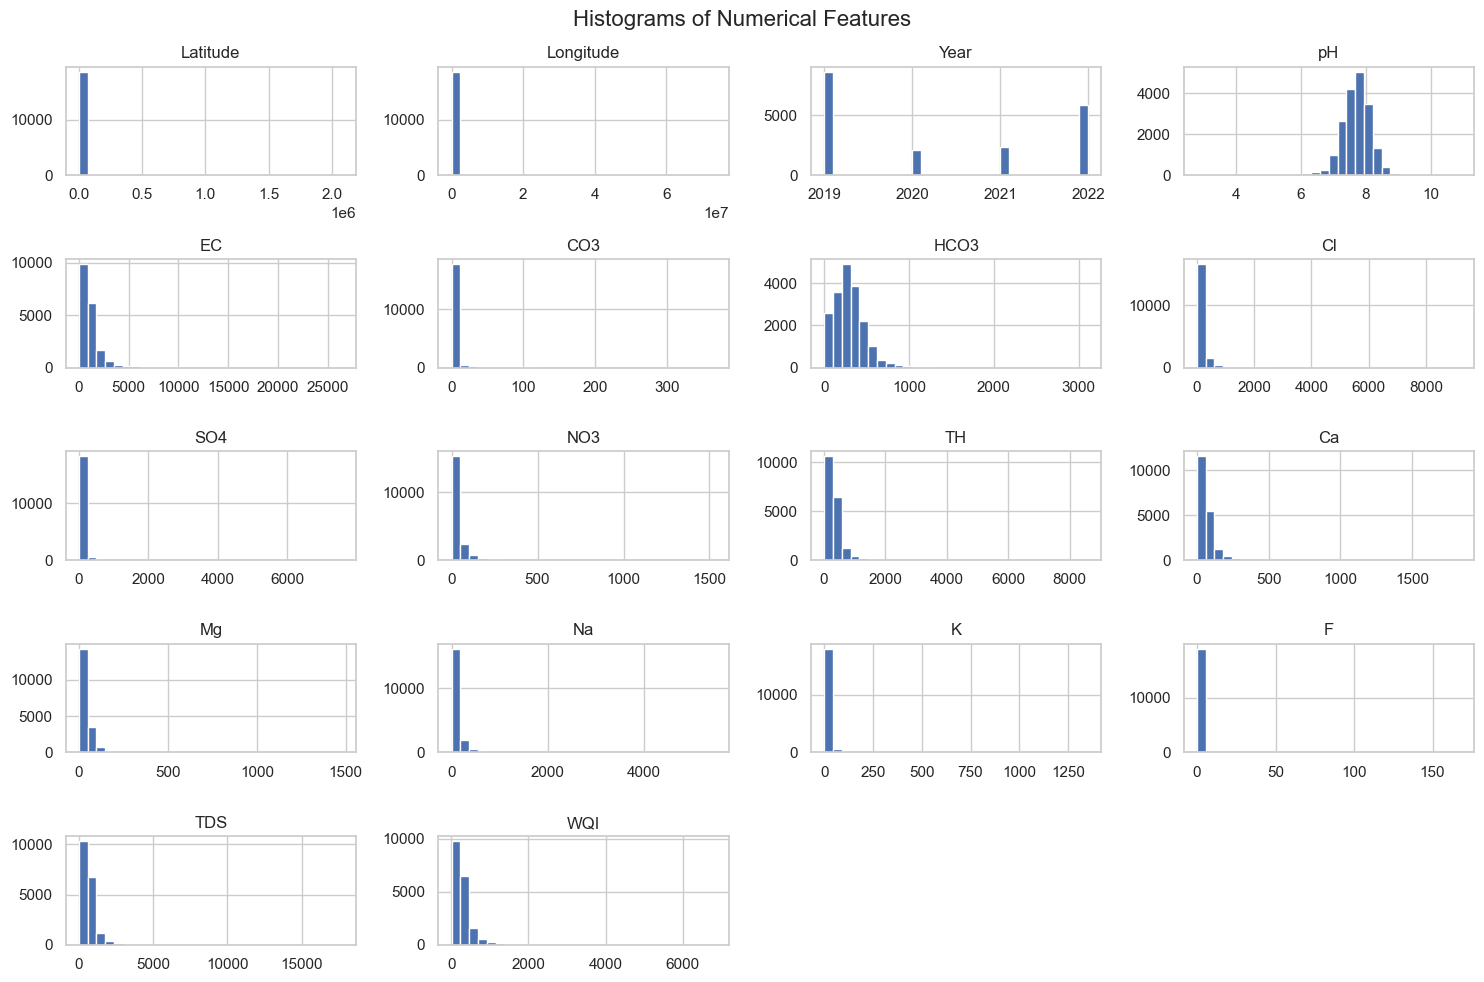

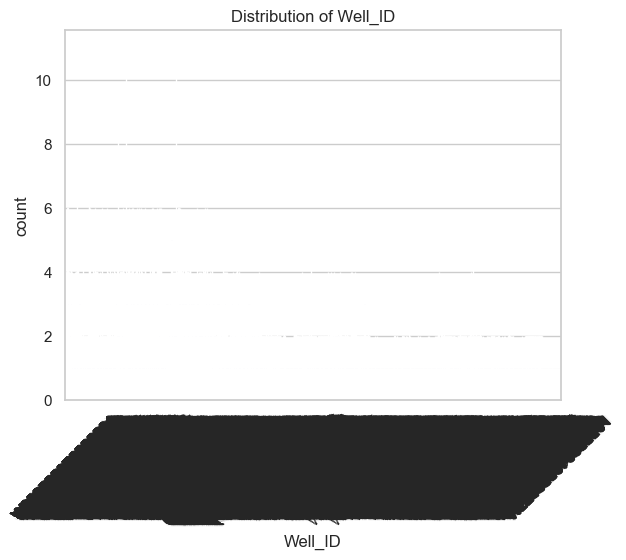

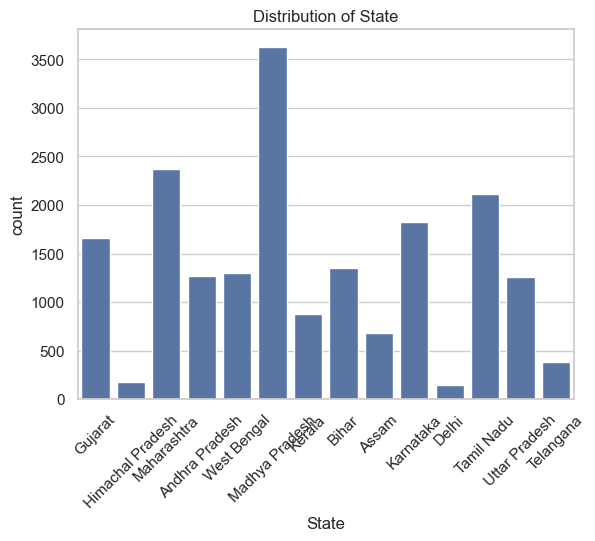

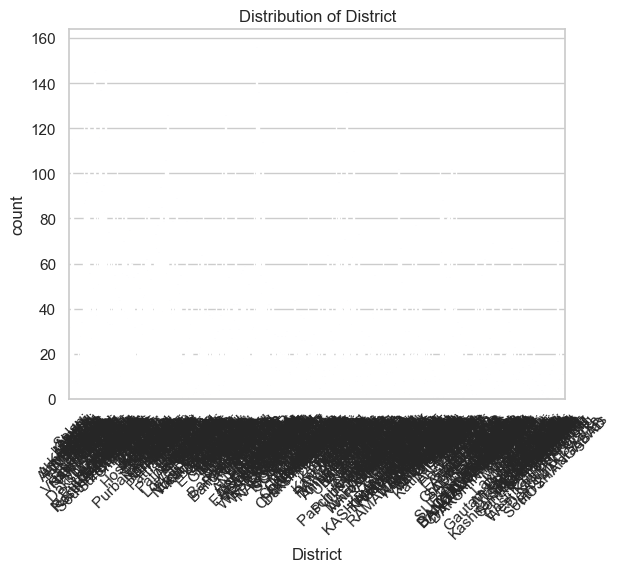

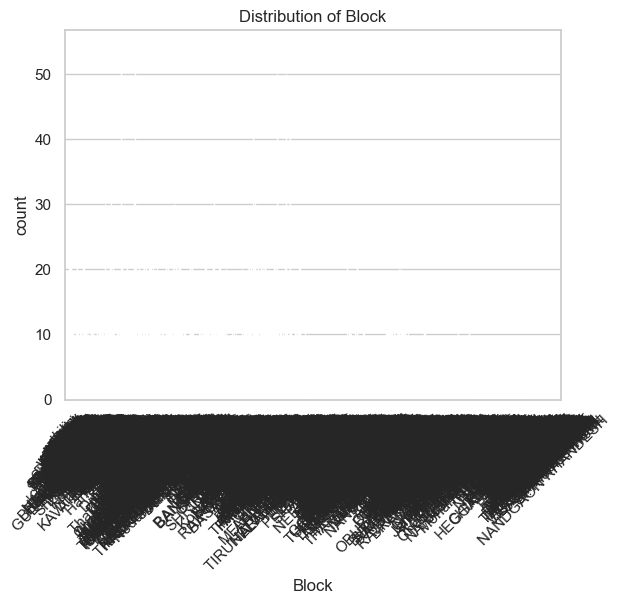

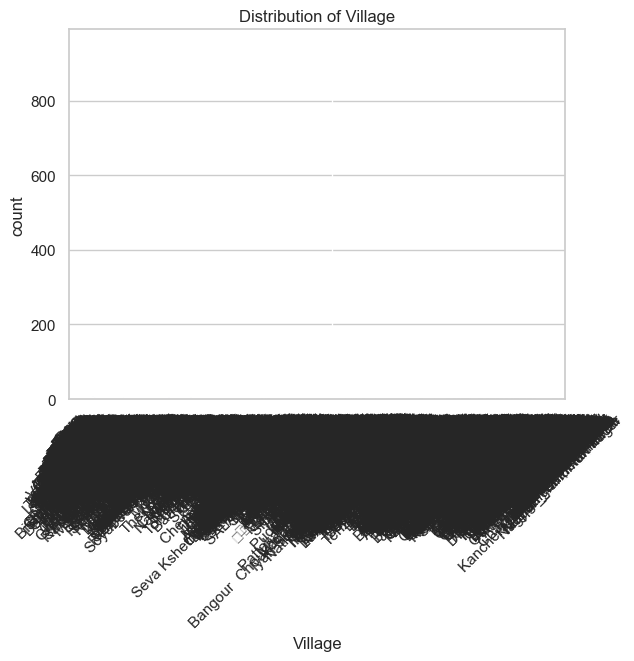

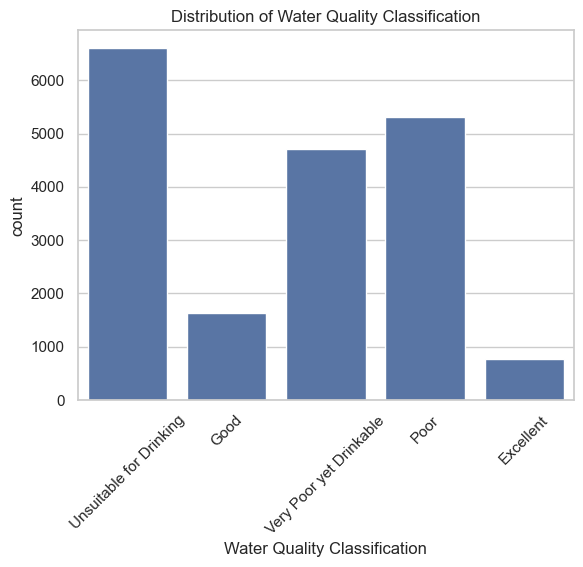


[Preprocessing Step Started]
Missing values before:
 Well_ID                         3785
State                              0
District                           0
Block                           1119
Village                            1
Latitude                         389
Longitude                        390
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64
Missing values after:
 Well_ID               

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# Check Columns
print("\nColumns in dataset:")
print(df.columns)

# ========== CLASS DISTRIBUTION ==========
# Attempt to auto-detect the target label column (excluding WQI)
potential_label_cols = [col for col in df.columns if col.lower() in ['water quality level', 'water_quality', 'water_quality_level', 'label', 'class', 'quality']]
if potential_label_cols:
    label_col = potential_label_cols[0]
    print(f"\nDetected target label column for classification: {label_col}")
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=label_col, palette="Set2", order=df[label_col].value_counts().index)
    plt.title("Class Distribution of Water Quality", fontsize=14)
    plt.xlabel("Water Quality Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Could not find a water quality classification column for class distribution plot.")

# ========== WQI DISTRIBUTION ==========
if 'WQI' in df.columns:
    sns.histplot(df['WQI'], kde=True)
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.show()

    sns.boxplot(x=df['WQI'])
    plt.title("Boxplot of WQI")
    plt.show()

    # Correlation with Other Features
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)

    print("\nCorrelation with WQI:")
    print(wqi_corr)

    # Heatmap for top correlations
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("⚠️ 'WQI' column not found.")

# Identify Categorical vs Numerical
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\nCategorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check for Identifier Columns
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# ================================
# 🔧 Preprocessing Before Modeling
# ================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("\n[Preprocessing Step Started]")

# Step 1: Handle Missing Values
print("Missing values before:\n", df.isnull().sum())
df = df.dropna()
print("Missing values after:\n", df.isnull().sum())

# Step 2: Encode Categorical Features
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 3: Scale Numerical Features
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

# Step 4: Prepare X and y
if 'WQI' in df.columns:
    X = df.drop("WQI", axis=1)
    y = df["WQI"]

    # Step 5: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training and testing data prepared.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
else:
    print("WQI not found. Please check column names.")

# ================================
# End of Script
# ================================


Shape of dataset: (19029, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                     

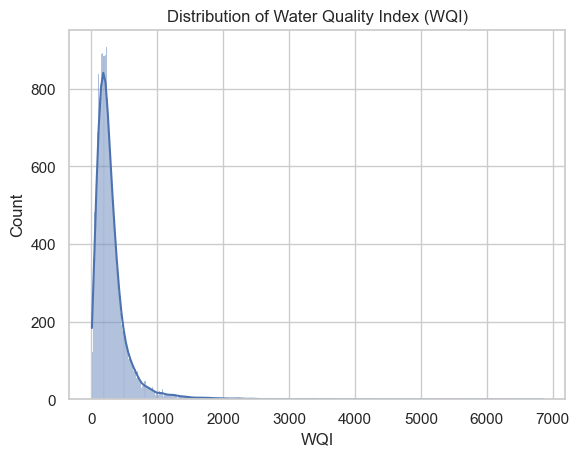

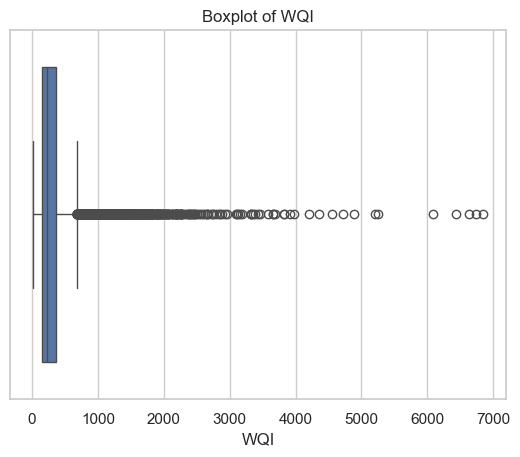


Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64


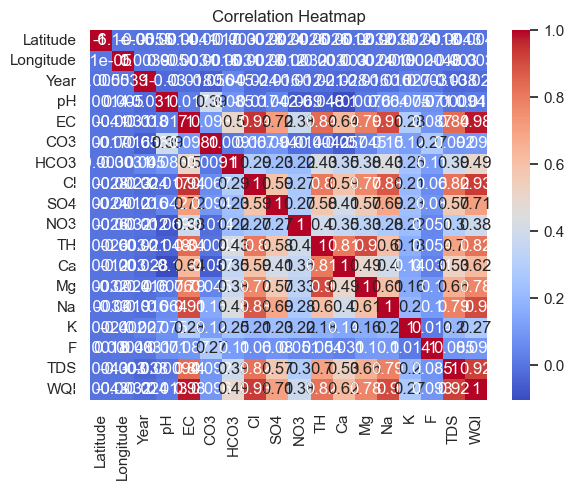


Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']
Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']


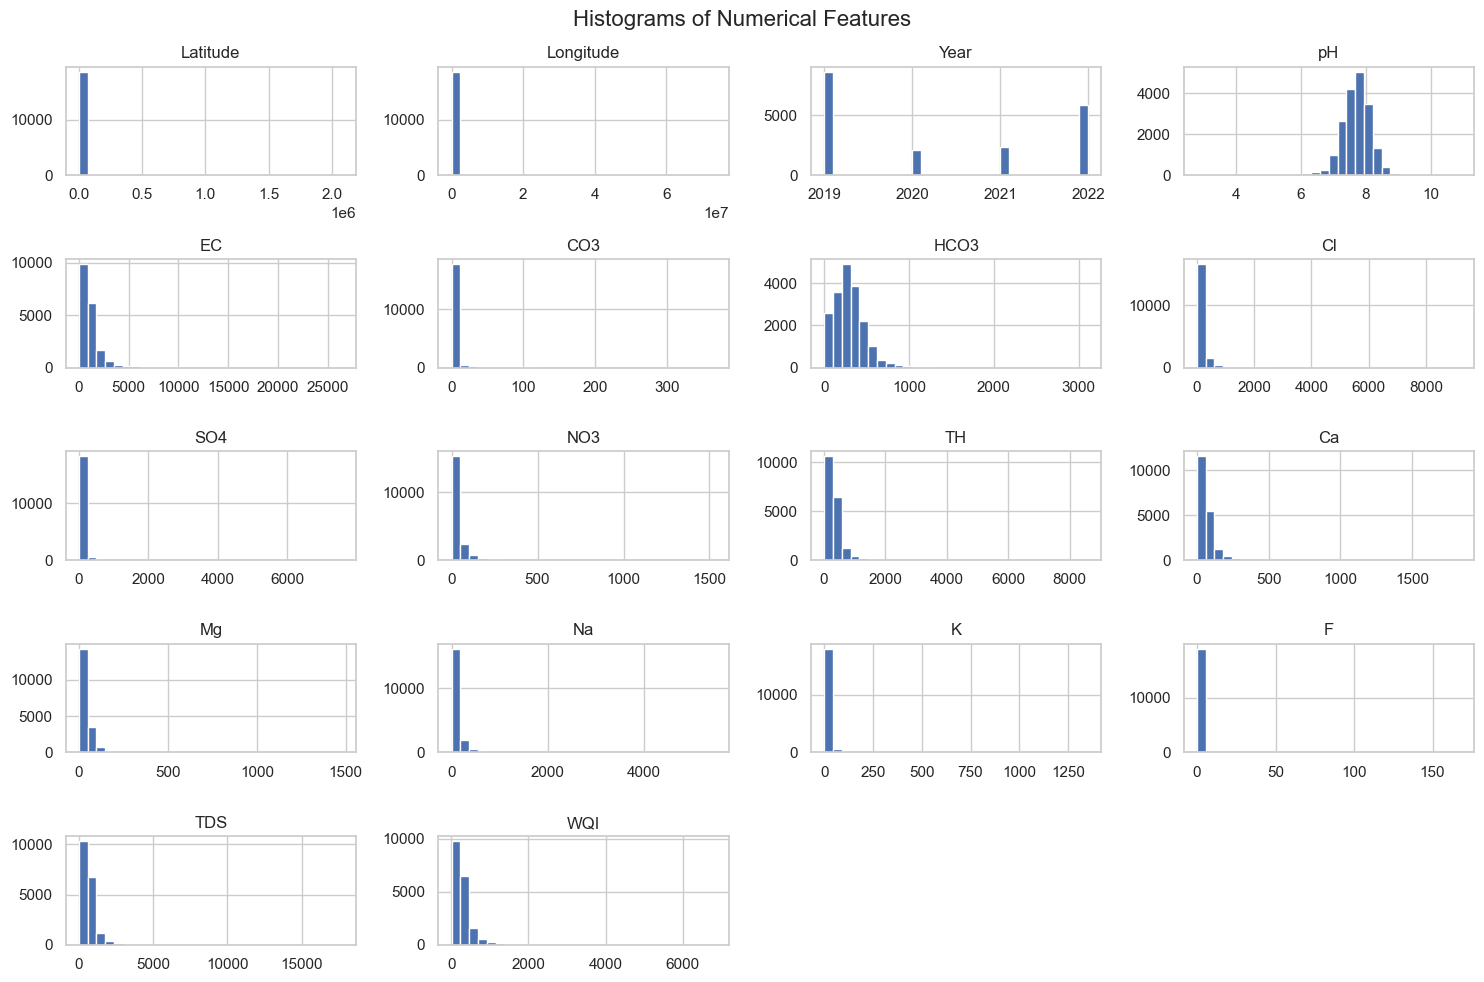

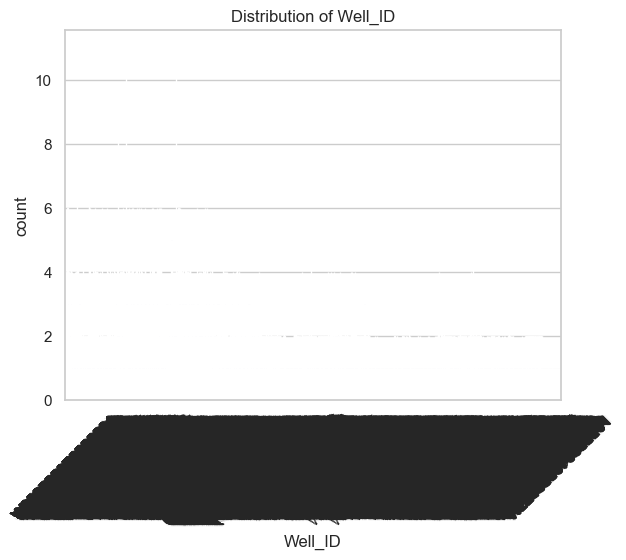

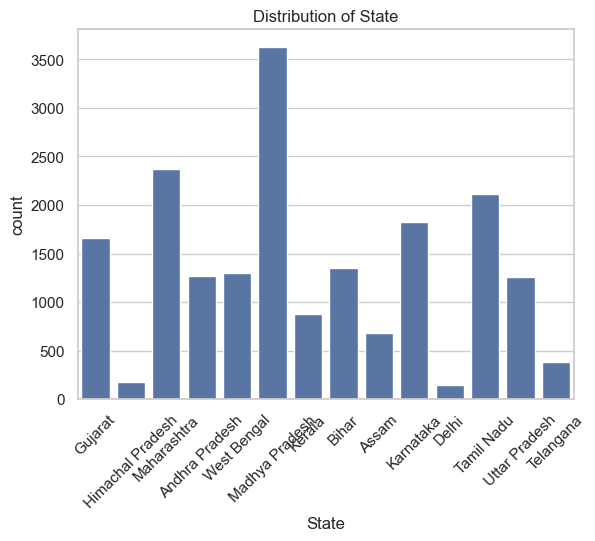

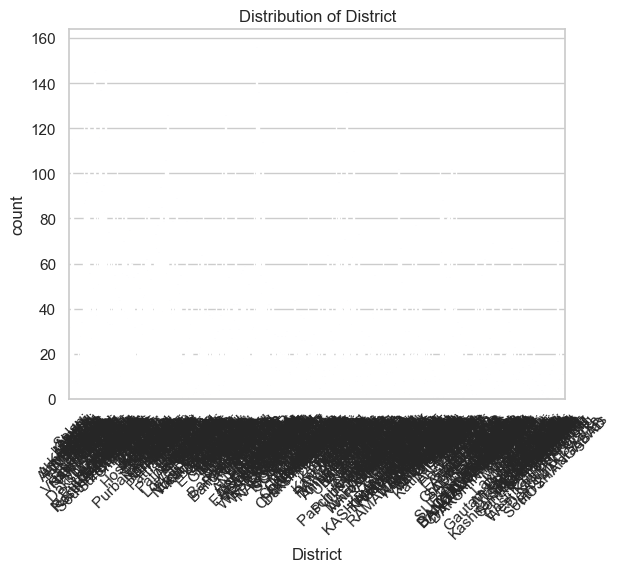

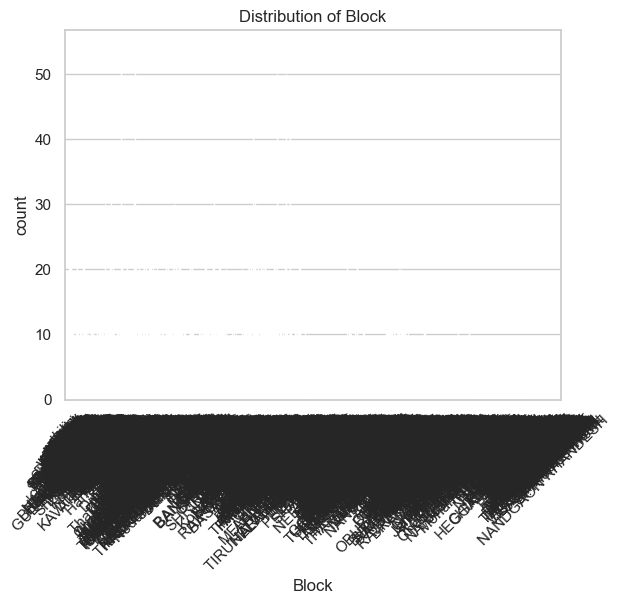

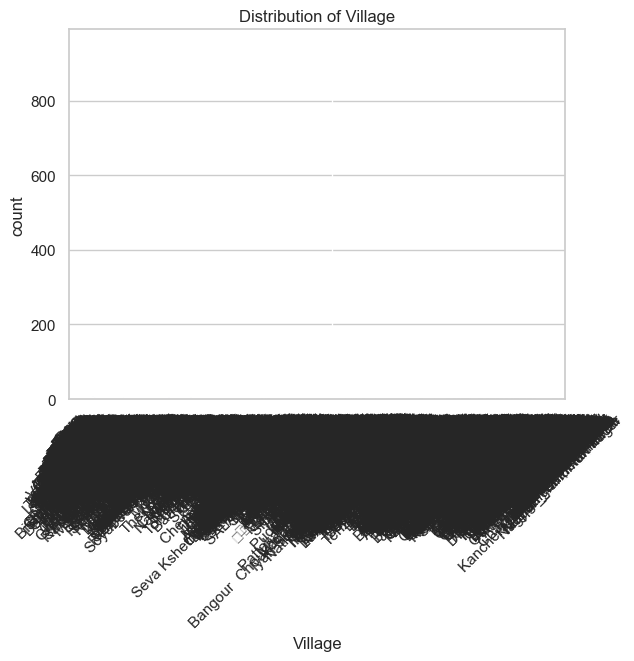

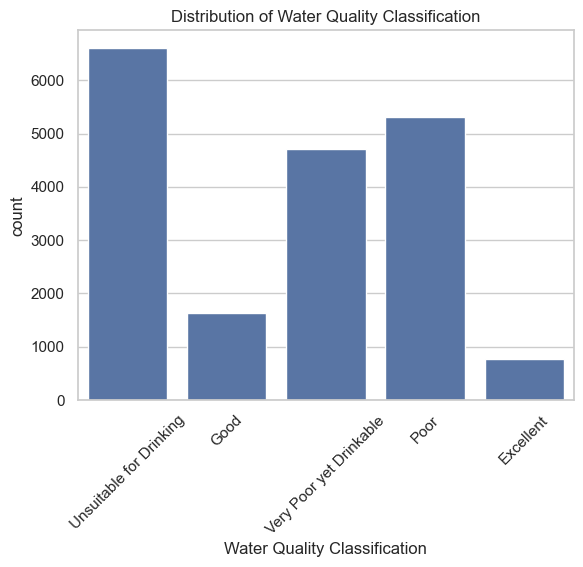


[Preprocessing Step Started]
Missing values before:
 Well_ID                         3785
State                              0
District                           0
Block                           1119
Village                            1
Latitude                         389
Longitude                        390
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64
Missing values after:
 Well_ID               

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# Inspect Data Shape, Info, Describe
print("Shape of dataset:", df.shape)
print("\nInfo:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# Check if WQI is in the dataset
print("\nColumns in dataset:")
print(df.columns)  # Ensure 'WQI' exists

# Check WQI Distribution
sns.histplot(df['WQI'], kde=True)
plt.title("Distribution of Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.show()

sns.boxplot(x=df['WQI'])
plt.title("Boxplot of WQI")
plt.show()

# Correlation with Other Features
correlation = df.corr(numeric_only=True)
wqi_corr = correlation['WQI'].sort_values(ascending=False)

print("\nCorrelation with WQI:")
print(wqi_corr)

# Heatmap for top correlations
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Identify Categorical vs Numerical (EDA)
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\nCategorical Columns:", categorical)
print("Numerical Columns:", numerical)

# Check for Identifier Columns
for col in df.columns:
    if df[col].is_unique:
        print(f"{col} is likely an identifier column.")

# Feature Distributions
# Histograms for numerical features
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# ================================
# 🔧 Preprocessing Before Modeling
# ================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("\n[Preprocessing Step Started]")

# Step 1: Handle Missing Values
print("Missing values before:\n", df.isnull().sum())
df = df.dropna()  # or you can use df.fillna(method='ffill') or df.fillna(df.mean())
print("Missing values after:\n", df.isnull().sum())

# Step 2: Encode Categorical Features
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 3: Scale Numerical Features
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

# Step 4: Prepare X and y
if 'WQI' in df.columns:
    X = df.drop("WQI", axis=1)
    y = df["WQI"]

    # Step 5: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training and testing data prepared.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
else:
    print("WQI not found. Please check column names.")

# ================================
# End of Script
# ================================


📊 Shape of Dataset: (19029, 24)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl         

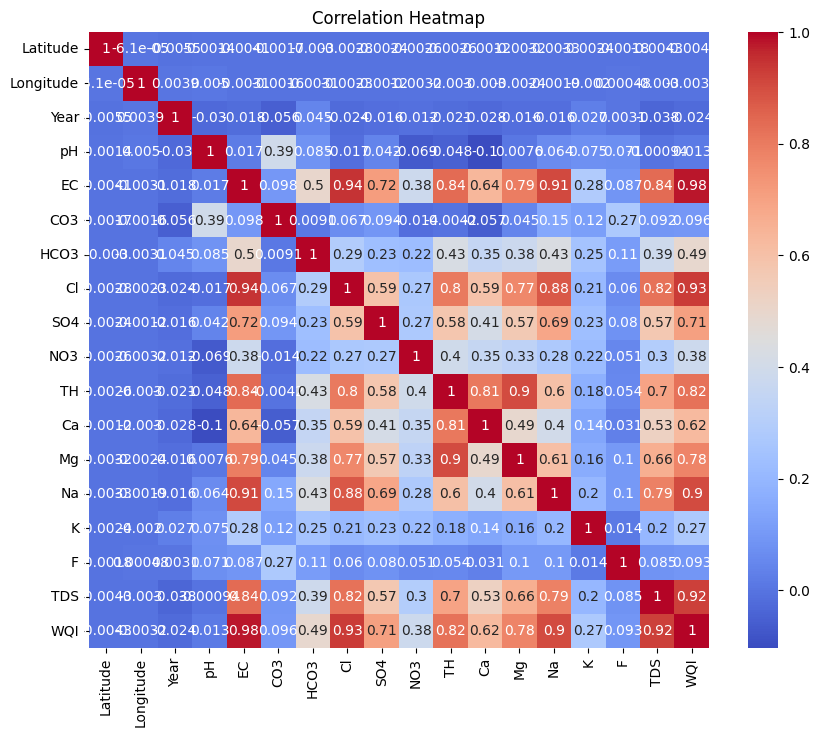

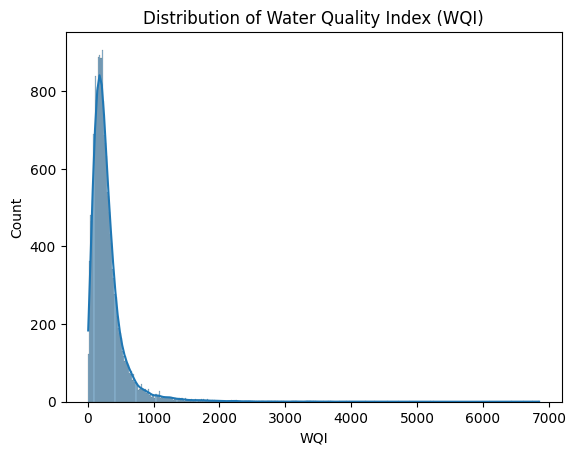

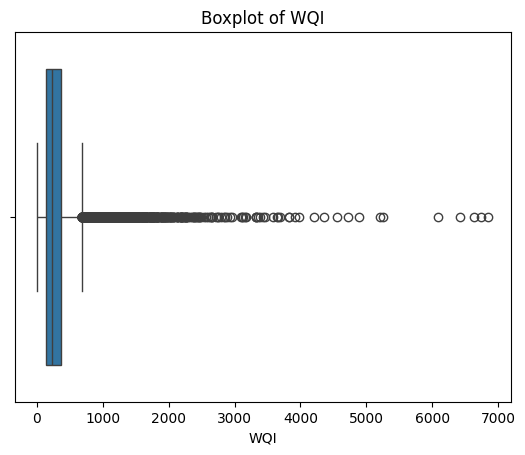

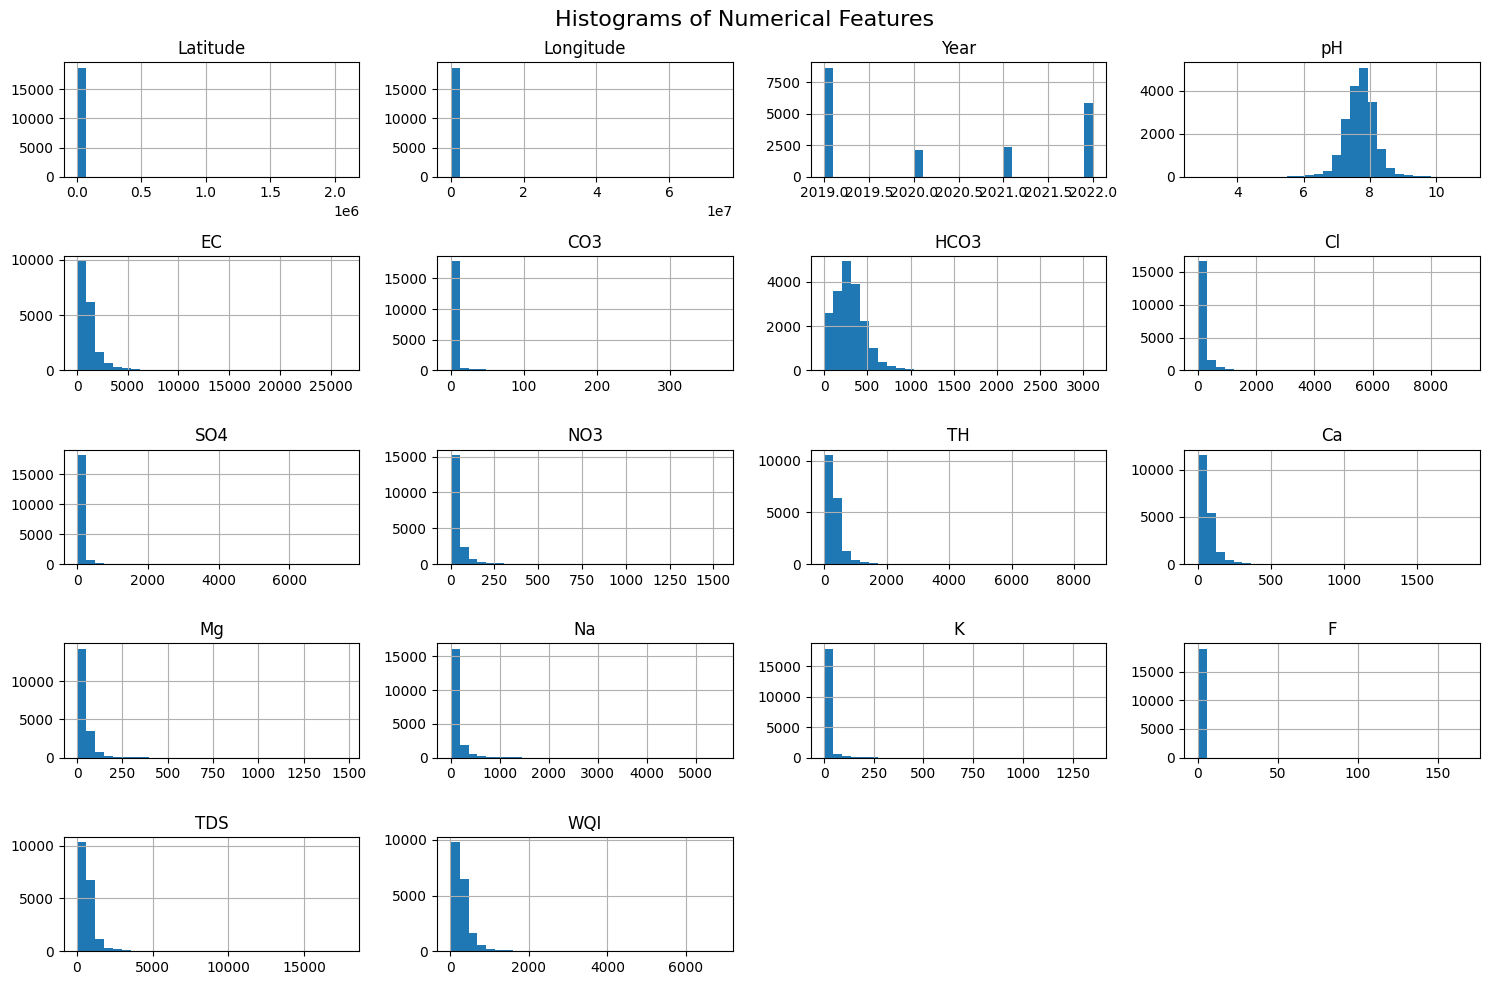

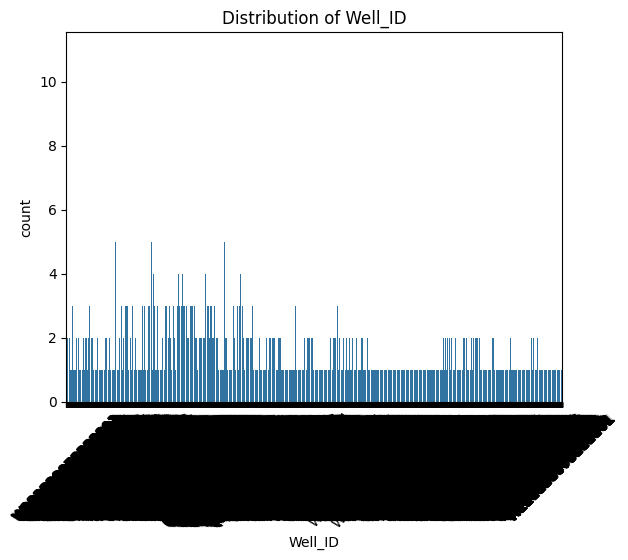

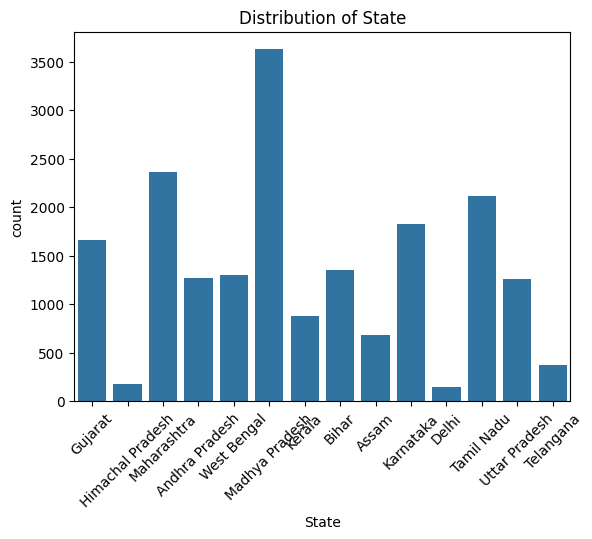

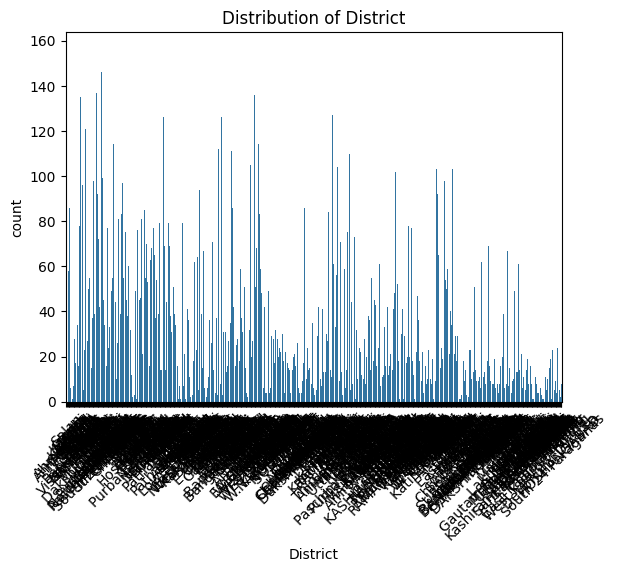

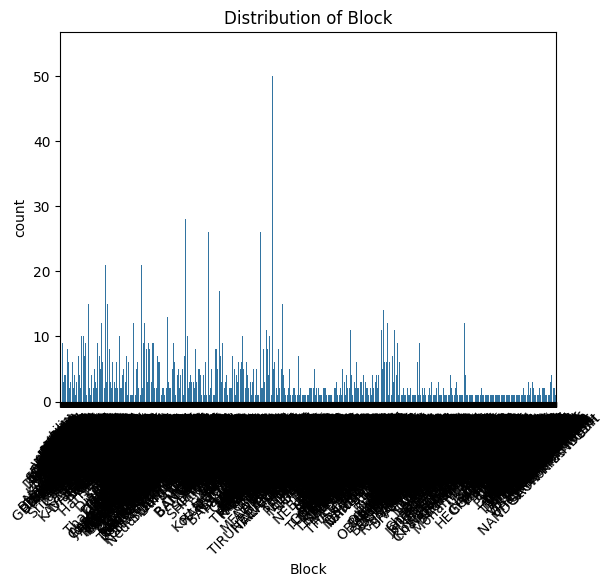

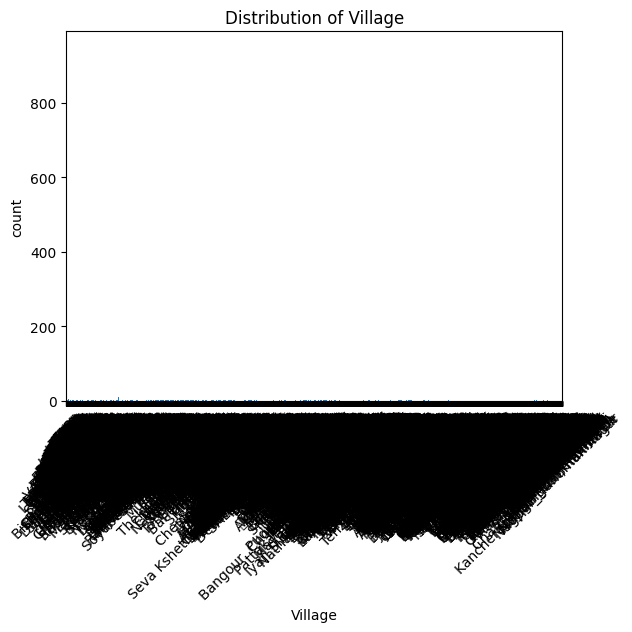

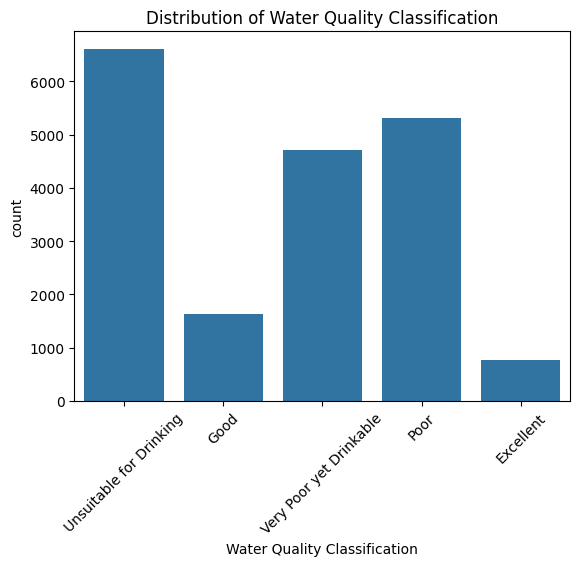

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# ======================
# Basic Dataset Overview
# ======================
print("📊 Shape of Dataset:", df.shape)

# Data Info
print("\n🧾 Dataset Info:")
df.info()

# Summary Statistics
print("\n📈 Summary Statistics:")
print(df.describe())

# Column Names
print("\n📋 Columns in Dataset:")
print(df.columns.tolist())

# ======================
# Categorical vs Numerical
# ======================
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\n🔢 Numerical Columns:", numerical)
print("🔠 Categorical Columns:", categorical)

# ======================
# Identifier Check
# ======================
for col in df.columns:
    if df[col].is_unique:
        print(f"🆔 '{col}' is likely an identifier column.")

# ======================
# Correlation with WQI
# ======================
if 'WQI' in df.columns:
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)
    print("\n🔗 Correlation with WQI:")
    print(wqi_corr)

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # WQI Distribution
    sns.histplot(df['WQI'], kde=True)
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.show()

    sns.boxplot(x=df['WQI'])
    plt.title("Boxplot of WQI")
    plt.show()

# ======================
# Feature Distributions
# ======================
# Histograms for numerical features
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


📊 Shape of Dataset: (19029, 24)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl         

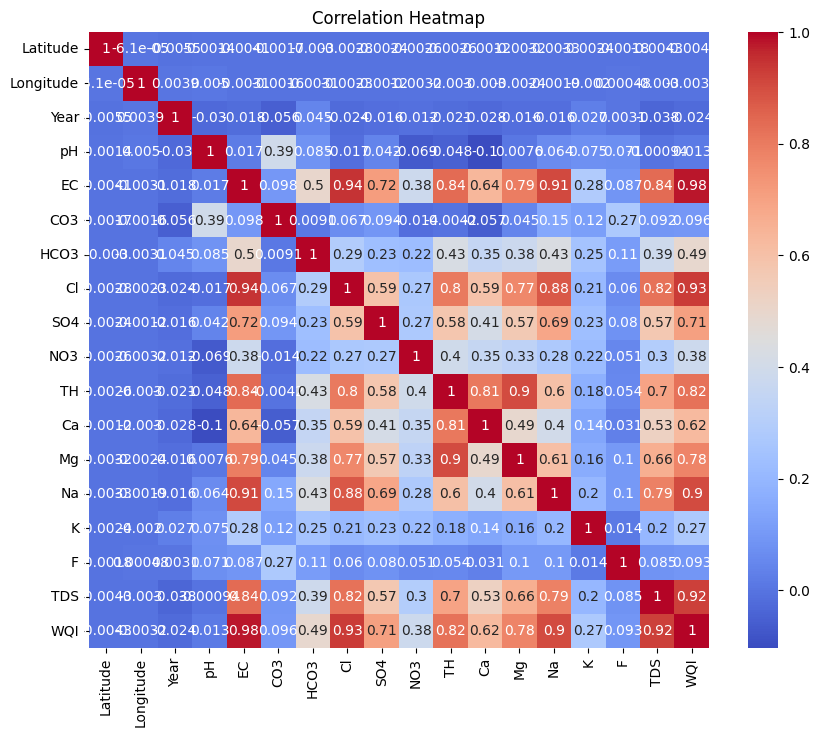

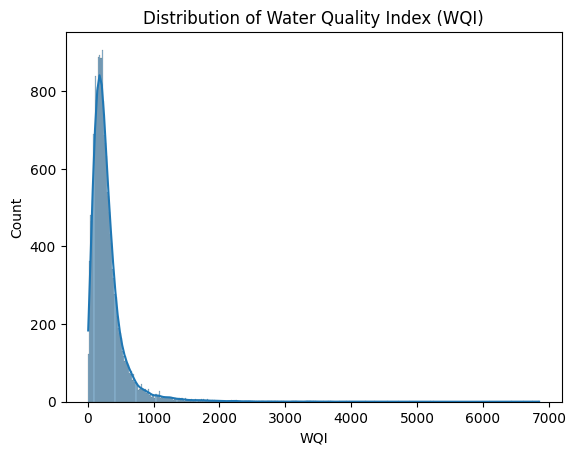

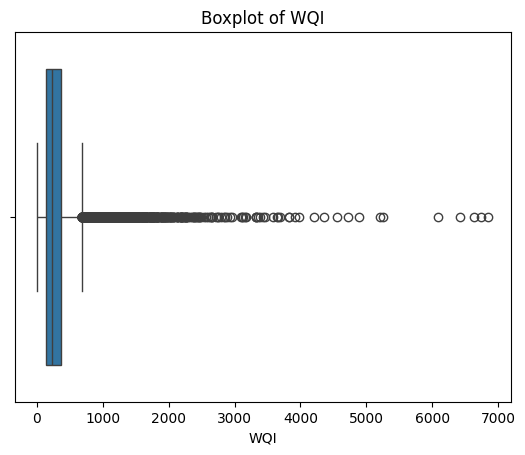


📊 WQI Value Counts Table:
WQI
9.043604       1
9.694329       1
10.050800      1
10.217600      1
11.404920      1
              ..
6092.045940    1
6427.241260    1
6626.592680    1
6744.379340    1
6850.888720    1
Name: count, Length: 18934, dtype: int64


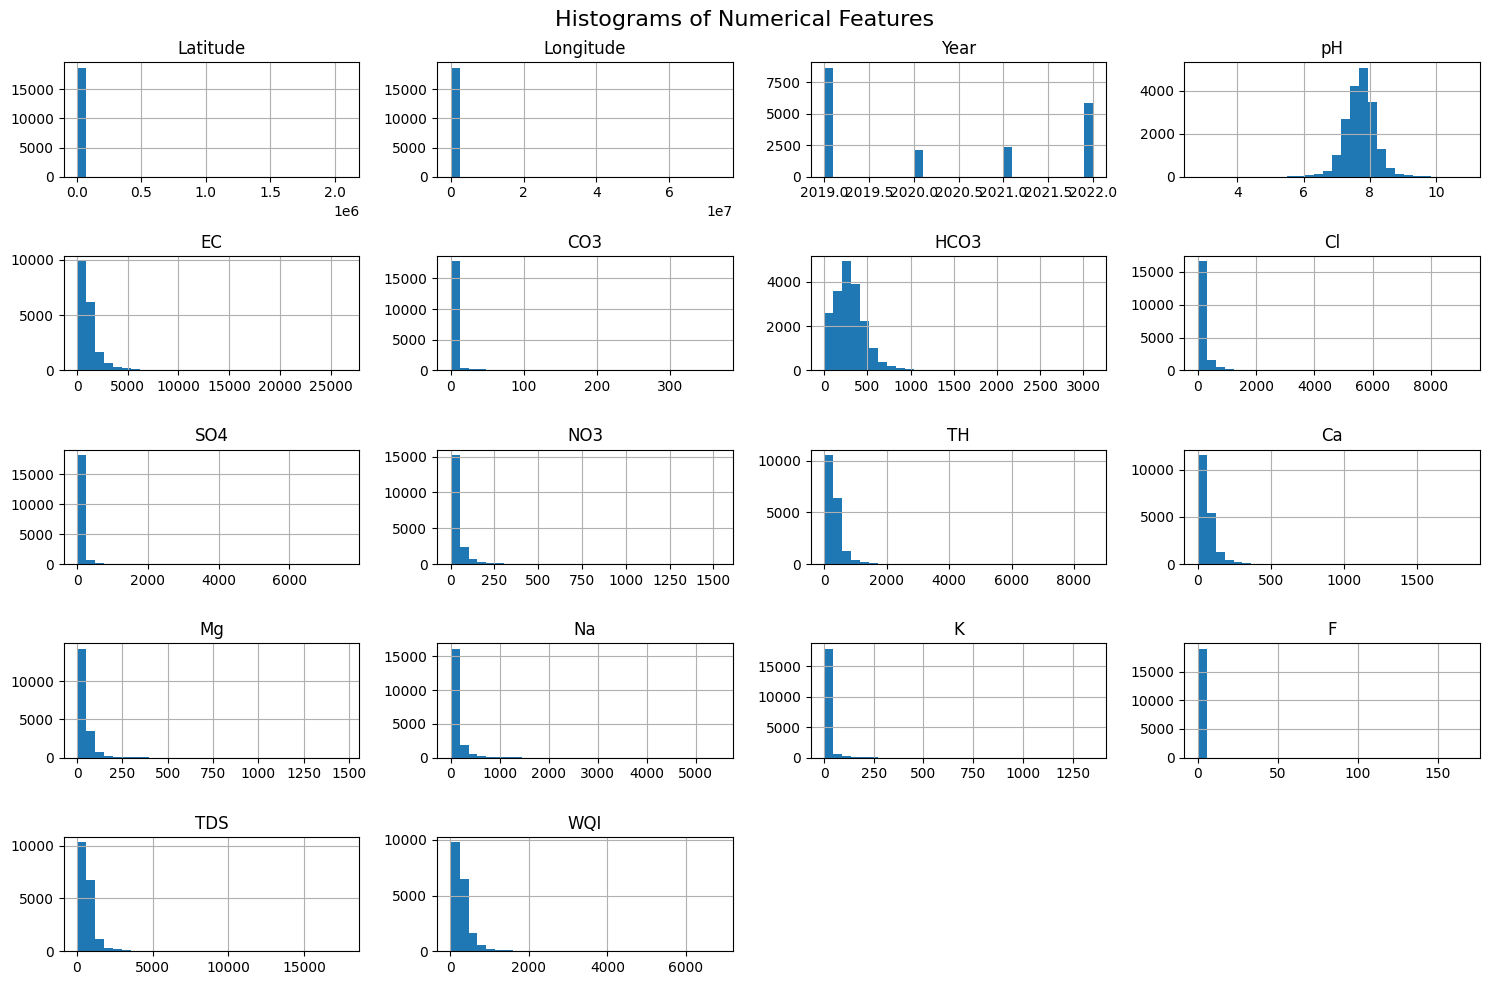

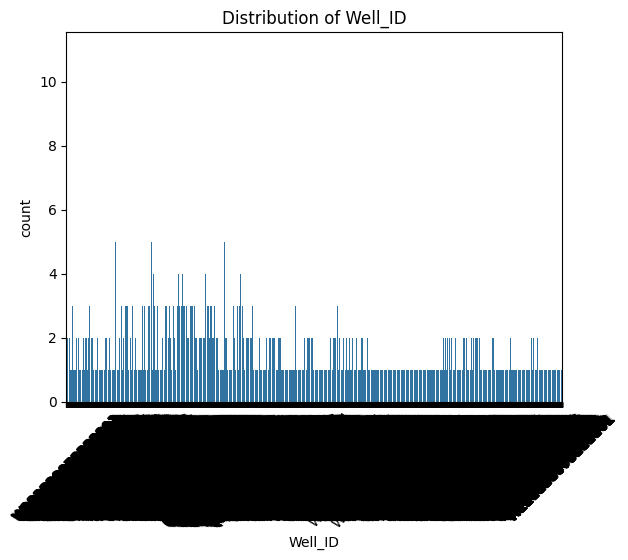

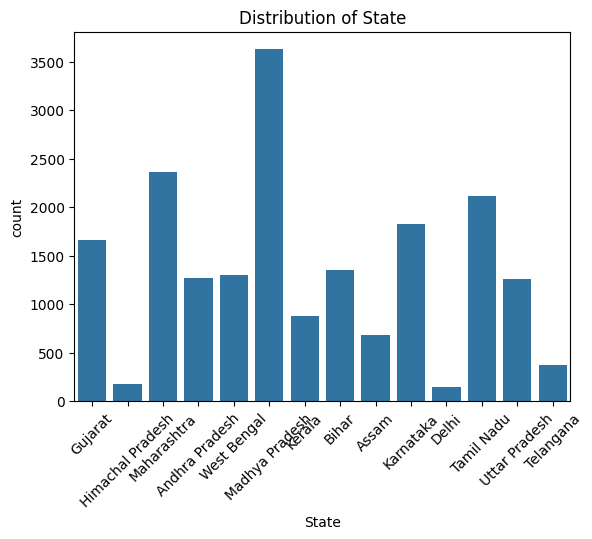

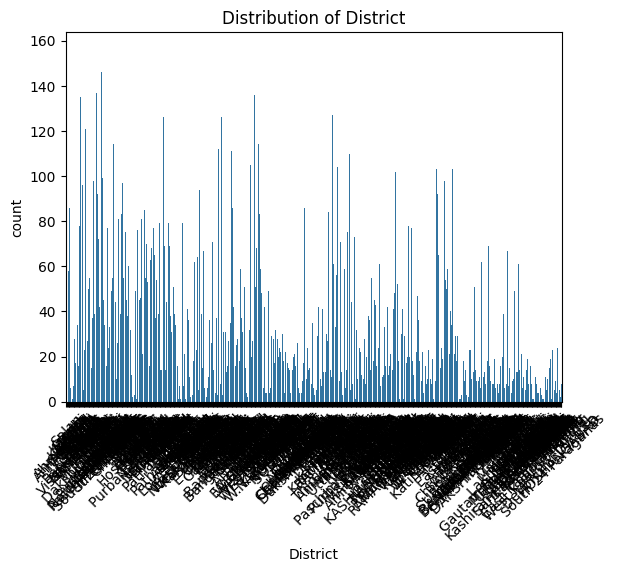

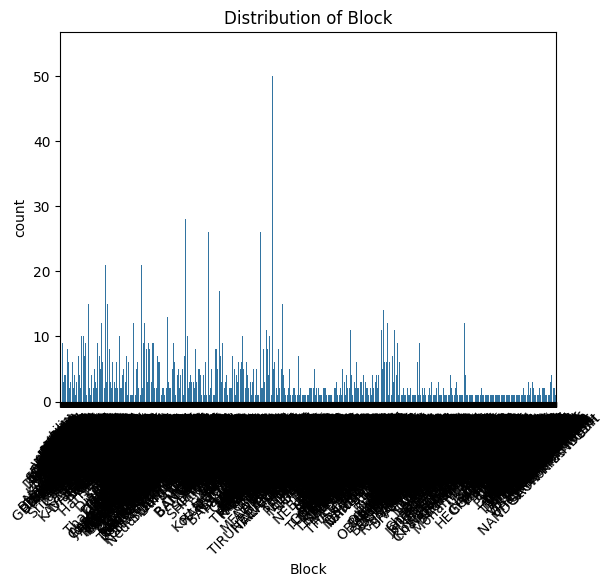

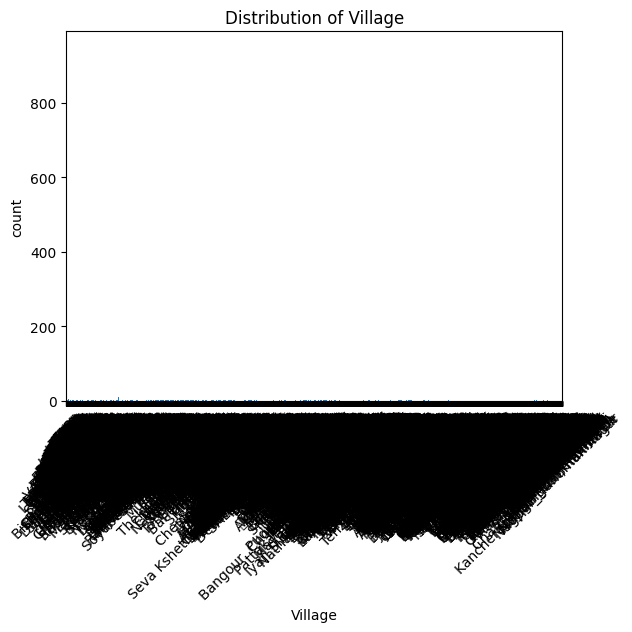

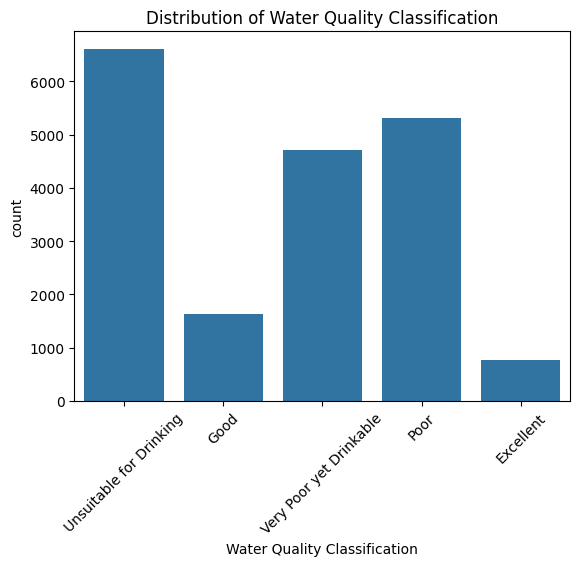


[Preprocessing Step Started]
Missing values before:
 Well_ID                         3785
State                              0
District                           0
Block                           1119
Village                            1
Latitude                         389
Longitude                        390
Year                               0
pH                                 0
EC                                 0
CO3                                0
HCO3                               0
Cl                                 0
SO4                                0
NO3                                0
TH                                 0
Ca                                 0
Mg                                 0
Na                                 0
K                                  0
F                                  0
TDS                                0
WQI                                0
Water Quality Classification       0
dtype: int64
Missing values after:
 Well_ID               

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings("ignore")

# ======================
# 1. Load Dataset
# ======================
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# ======================
# 2. Basic Dataset Overview
# ======================
print("📊 Shape of Dataset:", df.shape)
print("\n🧾 Dataset Info:")
df.info()
print("\n📈 Summary Statistics:")
print(df.describe())
print("\n📋 Columns in Dataset:")
print(df.columns.tolist())

# ======================
# 3. Categorical vs Numerical Features
# ======================
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\n🔢 Numerical Columns:", numerical)
print("🔠 Categorical Columns:", categorical)

# ======================
# 4. Identifier Check
# ======================
for col in df.columns:
    if df[col].is_unique:
        print(f"🆔 '{col}' is likely an identifier column.")

# ======================
# 5. Correlation and Distribution (WQI Insight)
# ======================
if 'WQI' in df.columns:
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)
    print("\n🔗 Correlation with WQI:")
    print(wqi_corr)

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # Distribution plots
    sns.histplot(df['WQI'], kde=True)
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.show()

    sns.boxplot(x=df['WQI'])
    plt.title("Boxplot of WQI")
    plt.show()

    # Table version of distribution
    print("\n📊 WQI Value Counts Table:")
    print(df['WQI'].value_counts().sort_index())

# ======================
# 6. Feature Distributions
# ======================
# Histograms for numerical features
df[numerical].hist(figsize=(15, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Count plots for categorical features
for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# ================================
# 7. 🔧 Preprocessing
# ================================

print("\n[Preprocessing Step Started]")

# Step 1: Handle Missing Values
print("Missing values before:\n", df.isnull().sum())
df = df.dropna()  # Or: df.fillna(method='ffill') or df.fillna(df.mean())
print("Missing values after:\n", df.isnull().sum())

# Step 2: Encode Categorical Features
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Step 3: Scale Numerical Features
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

# Step 4: Prepare Features and Target
if 'WQI' in df.columns:
    X = df.drop("WQI", axis=1)
    y = df["WQI"]

    # Step 5: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("✅ Data split for modeling.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
else:
    print("⚠️ WQI column not found. Please verify dataset.")

# ================================
# End of Script
# ================================



📊 Shape of Dataset: (19029, 24)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl         

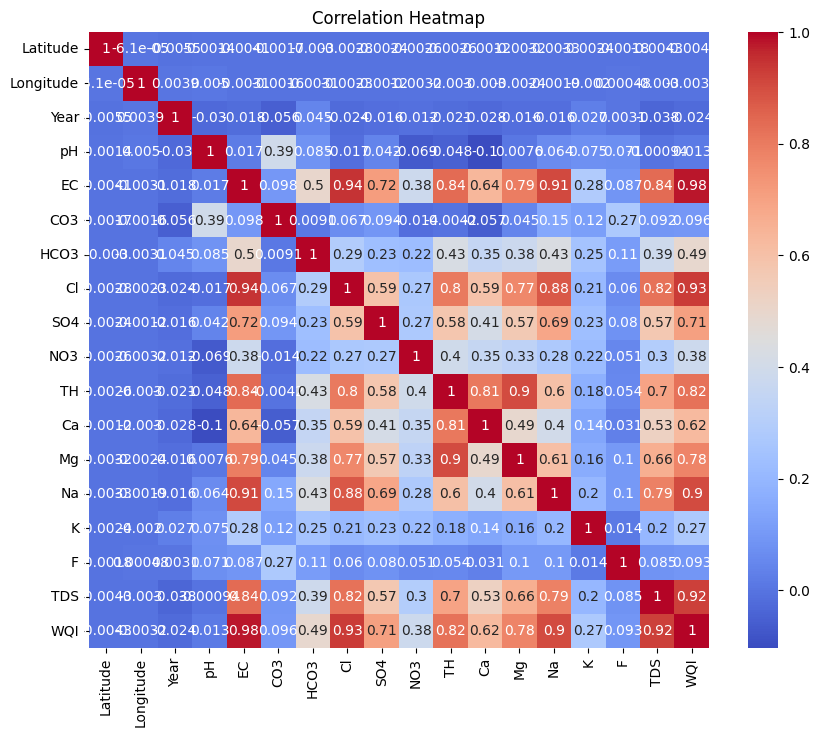

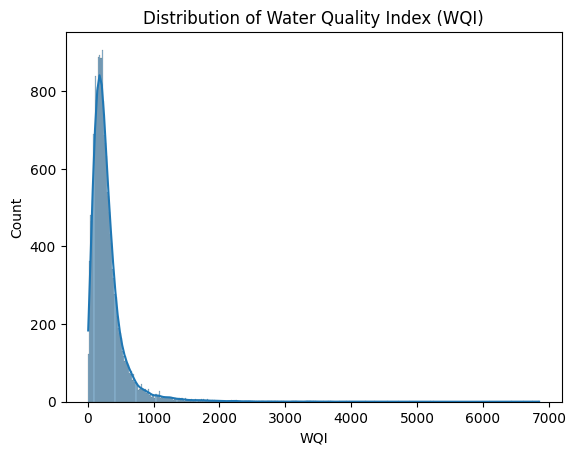

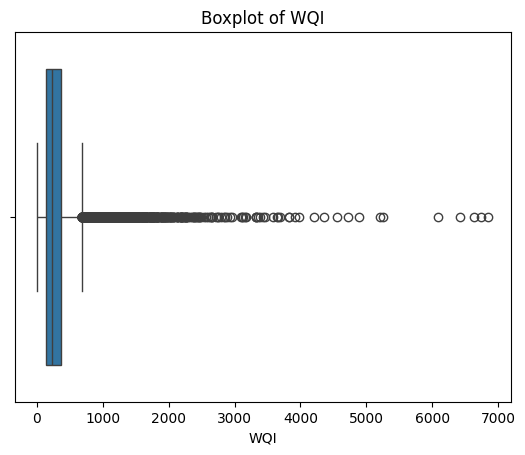


📊 WQI Value Counts Table:
WQI
9.043604       1
9.694329       1
10.050800      1
10.217600      1
11.404920      1
              ..
6092.045940    1
6427.241260    1
6626.592680    1
6744.379340    1
6850.888720    1
Name: count, Length: 18934, dtype: int64


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ======================
# 1. Load Dataset
# ======================
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# ======================
# 2. Basic Dataset Overview
# ======================
print("📊 Shape of Dataset:", df.shape)
print("\n🧾 Dataset Info:")
df.info()
print("\n📈 Summary Statistics:")
print(df.describe())
print("\n📋 Columns in Dataset:")
print(df.columns.tolist())

# ======================
# 3. Categorical vs Numerical Features
# ======================
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\n🔢 Numerical Columns:", numerical)
print("🔠 Categorical Columns:", categorical)

# ======================
# 4. Identifier Check
# ======================
for col in df.columns:
    if df[col].is_unique:
        print(f"🆔 '{col}' is likely an identifier column.")

# ======================
# 5. Correlation and Distribution (WQI Insight)
# ======================
if 'WQI' in df.columns:
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)
    print("\n🔗 Correlation with WQI:")
    print(wqi_corr)

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # Distribution plots
    sns.histplot(df['WQI'], kde=True)
    plt.title("Distribution of Water Quality Index (WQI)")
    plt.xlabel("WQI")
    plt.show()

    sns.boxplot(x=df['WQI'])
    plt.title("Boxplot of WQI")
    plt.show()

    # Table version of distribution
    print("\n📊 WQI Value Counts Table:")
    print(df['WQI'].value_counts().sort_index())
else:
    print("⚠️ WQI column not found. Please verify dataset.")


📊 Shape of Dataset: (19029, 24)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl         

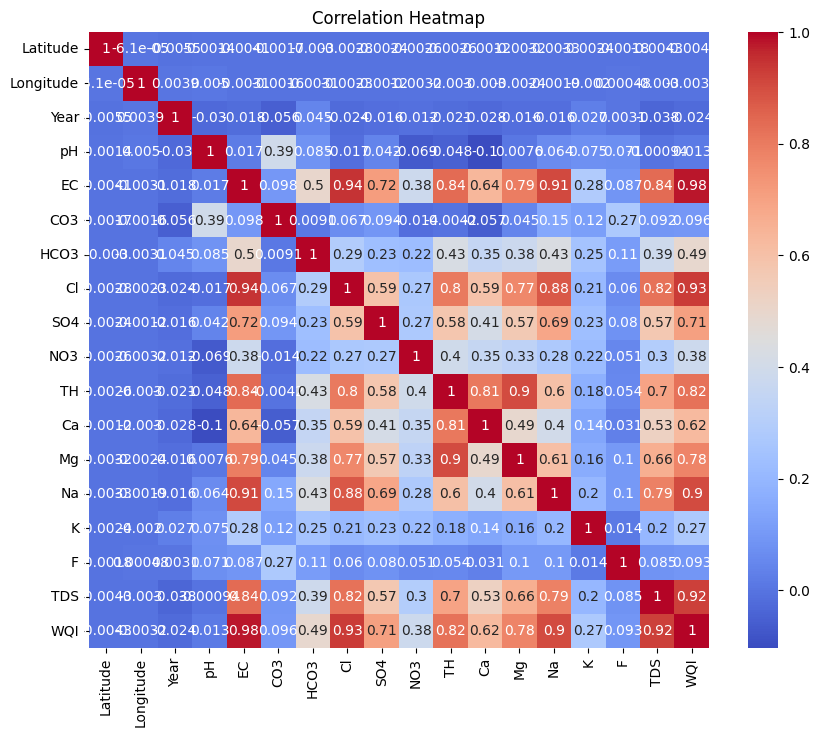

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ======================
# 1. Load Dataset
# ======================
df = pd.read_csv("D:/UMS/sem 6/KT34203/Machine Learning_GroupProject/water_quality.csv")

# ======================
# 2. Basic Dataset Overview
# ======================
print("📊 Shape of Dataset:", df.shape)
print("\n🧾 Dataset Info:")
df.info()
print("\n📈 Summary Statistics:")
print(df.describe())
print("\n📋 Columns in Dataset:")
print(df.columns.tolist())

# ======================
# 3. Categorical vs Numerical Features
# ======================
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include='number').columns.tolist()

print("\n🔢 Numerical Columns:", numerical)
print("🔠 Categorical Columns:", categorical)

# ======================
# 4. Identifier Check
# ======================
for col in df.columns:
    if df[col].is_unique:
        print(f"🆔 '{col}' is likely an identifier column.")

# ======================
# 5. Correlation and Distribution (WQI Insight)
# ======================
if 'WQI' in df.columns:
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)
    print("\n🔗 Correlation with WQI:")
    print(wqi_corr)

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("⚠️ WQI column not found. Please verify dataset.")